**Excersize 2:**

**1.1.1 Transfer Learning from ImageNet**

- Download and prepare CIFAR-10 dataset

- Use AlexNet as the model (Pytorch AlexNet)

    - Train the model for CIFAR-10 data, Report the test test accuracy. (also referred as fine tuning the model)
    - Use the pretarined weights of AlexNet for image classification on CIFAR-10 data (also referred as Feature Extraction).
    - Report the accuracy on the test set

- In both the above cases remember to add an extra fully connected layer to the classifier with number of neurons = 10, because there are 10 classes in CIFAR-10 dataset. This layer will be trainable in both the cases.

**1.1.2 Transfer Learning from MNIST**

- Prepare a CNN of your choice and train it on the MNIST data. Report the accuracy.

- Use the above model as a pretrained CNN for the SVHN dataset. Report the accuracy.

- In the third step you are performing transfer learining from MNIST to SVHN.

In [ ]:
import os
import re
import copy
import time
import glob
import shutil
import pickle
import tarfile
import zipfile
import datetime
import subprocess
import numpy as np
import pandas as pd
import urllib.request
import seaborn as sns
from PIL import Image
from copy import deepcopy
from tqdm.auto import tqdm
from tabulate import tabulate
from google.colab import drive
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torchvision.datasets import CIFAR10
from torchvision.datasets import MNIST
from matplotlib.ticker import LogLocator
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import FuncFormatter
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import train_test_split
from torchvision.models import AlexNet, AlexNet_Weights
from sklearn.metrics import accuracy_score, average_precision_score, confusion_matrix, classification_report
from torchvision import datasets, models, transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
%load_ext tensorboard

In [ ]:
# Set the random seed for reproducibility
np.random.seed(42)

# Set the project folder
mount_point = '/content/drive/'
data_folder = '/content/data'

if not os.path.exists(mount_point):
    drive.mount(mount_point)
else:
    print(f"Drive is already mounted at {mount_point}")

os.chdir(os.path.join(mount_point))

# Delete existing data folders
if os.path.exists(data_folder):
    shutil.rmtree(data_folder)

if os.path.exists(os.path.join(mount_point,'/cifar-10')):
    shutil.rmtree(os.path.join(mount_point,'/cifar-10'))

if os.path.exists(os.path.join(mount_point,'/cifar-10-batches-py')):
    shutil.rmtree(os.path.join(mount_point,'/cifar-10-batches-py'))

# Create the data folder if it doesn't exist
if not os.path.exists(data_folder):
    os.makedirs(data_folder)

# Create the 'project' folder on Google Drive if it doesn't exist
project_folder = os.path.join(mount_point, 'MyDrive/D7047E/MNIST/')
if not os.path.exists(project_folder):
    os.makedirs(project_folder)
    print(f"\nProject folder created at {project_folder}")

# Create the 'accuracy' folder in the project folder on Google Drive if it doesn't exist
accuracy_folder = os.path.join(mount_point, project_folder, 'accuracy')
if not os.path.exists(accuracy_folder):
    os.makedirs(accuracy_folder)
    print(f"\naccuracy folder created at {accuracy_folder}")

# Create the 'softmax' folder in the project folder on Google Drive if it doesn't exist
softmax_folder = os.path.join(mount_point, project_folder, 'softmax')
if not os.path.exists(softmax_folder):
    os.makedirs(softmax_folder)
    print(f"\nsoftmax folder created at {softmax_folder}")

# Create the 'logs' folder in the project folder on Google Drive if it doesn't exist
logs_folder = os.path.join(mount_point, project_folder, 'logs')
if not os.path.exists(logs_folder):
    os.makedirs(logs_folder)
    print(f"\nlogs folder created at {logs_folder}")

# Create the 'checkpoints' folder in the project folder on Google Drive if it doesn't exist
checkpoint_folder = os.path.join(mount_point, project_folder, 'checkpoint')
if not os.path.exists(checkpoint_folder):
    os.makedirs(checkpoint_folder)
    print(f"\nCheckpoints folder created at {checkpoint_folder}")

os.chdir('/content/')

if not os.path.exists(data_folder):
    num_files = 0
else:
    num_files = 0
    for root, dirs, files in os.walk(data_folder):
        num_files += len(files)

print(f'\nThere are {num_files} files in the destination folder: {data_folder}\n')

# Download and extract CIFAR10 dataset
class customCIFAR10(CIFAR10):
    def __getitem__(self, index):
        img, target = super().__getitem__(index)
        img_path = self.data[index]
        return img, target, img_path

# Download and extract MNIST dataset
class customMNIST(MNIST):
    def __getitem__(self, index):
        img, target = super().__getitem__(index)
        img_path = self.data[index]
        return img, target, img_path


# Data transforms
transform = {
    'train': transforms.Compose([
        transforms.Resize(32),
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)) # MNIST
    ]),
    'valid': transforms.Compose([
        transforms.Resize(32),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)) # MNIST
    ]),
    'test': transforms.Compose([
        transforms.Resize(32),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)) # MNIST
    ]),
    'visualization': transforms.Compose([
        transforms.Resize(32),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
    ])
}

# Download and extract MNIST datasets
trainset = datasets.MNIST(root=data_folder, train=True, download=True, transform=transform['train'])
testset  = customMNIST(root=data_folder, train=False, download=True, transform=transform['test'])

# Rename the extracted folder from cifar-10-batches-py to cifar-10
if os.path.exists(os.path.join(data_folder, 'cifar-10-batches-py')):
    os.rename(os.path.join(data_folder, 'cifar-10-batches-py'), os.path.join(data_folder, 'cifar-10'))

# Remove the downloaded tar.gz file
src_file = 'cifar-10-python.tar.gz'
if os.path.exists(os.path.join(data_folder, src_file)):
    os.remove(os.path.join(data_folder, src_file))

print("\nMNIST dataset downloaded and extracted successfully.")

# Split trainset into validation and training using stratified sampling

trainset.targets = np.array(trainset.targets)
train_idx, val_idx = train_test_split(np.arange(len(trainset.targets)),
                                  test_size=0.2,
                                  stratify=trainset.targets,
                                  random_state=42)

# Verify splits are disjoint
assert set(train_idx).isdisjoint(set(val_idx)), "There are common elements between the training and validation splits"

# Create train_set and val_set from trainset
train_set = Subset(trainset, train_idx)
val_set = Subset(trainset, val_idx)

# Create dataloaders
batch_size = 128
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

dataloaders = {'train': train_loader, 'valid': val_loader, 'test': test_loader}

# Class labels for CIFAR-10 dataset
#class_names = ['airplanes', 'cars', 'birds', 'cats', 'deer', 'dogs', 'frogs', 'horses', 'ships', 'trucks']

# Class labels for MNIST & SVHN dataset
class_names = list(range(10))

# Save metrics to pickle files
pickle_files = [
    "MNIST_all_train_accuracies.pickle",
    "MNIST_all_train_losses.pickle",
    "MNIST_all_val_accuracies.pickle",
    "MNIST_all_val_losses.pickle",
    "MNIST_all_learning_rates.pickle",]

Drive is already mounted at /content/drive/

There are 0 files in the destination folder: /content/data



  0%|          | 0/182040794 [00:00<?, ?it/s]

  0%|          | 0/64275384 [00:00<?, ?it/s]


MNIST dataset downloaded and extracted successfully.


**CNN model architecture**:


Feature extraction layers (features): This part is a sequence of convolutional, ReLU activation, and max-pooling layers that process the input image and learn to extract relevant features. The layers are as follows:
********************
Convolutional layer (3 input channels, 64 output channels, 11x11 kernel, 4x4 stride, 2x2 padding)

ReLU activation (in-place)

Max-pooling layer (3x3 kernel, 2x2 stride)

Convolutional layer (64 input channels, 192 output channels, 5x5 kernel, 1x1 stride, 2x2 padding)

ReLU activation (in-place)

Max-pooling layer (3x3 kernel, 2x2 stride)

Convolutional layer (192 input channels, 384 output channels, 3x3 kernel, 1x1 stride, 1x1 padding)

ReLU activation (in-place)

Convolutional layer (384 input channels, 256 output channels, 3x3 kernel, 1x1 stride, 1x1 padding)

ReLU activation (in-place)

Convolutional layer (256 input channels, 256 output channels, 3x3 kernel, 1x1 stride, 1x1 padding)

ReLU activation (in-place)

Max-pooling layer (3x3 kernel, 2x2 stride)

Average pooling layer (avgpool): This layer performs adaptive average pooling, reducing the spatial dimensions of the feature maps to a fixed size (6x6 in this case).

Classification layers (classifier): This part is a sequence of fully connected layers, dropout layers, and ReLU activation layers that process the features extracted by the previous layers and output class scores. The layers are as follows:

Dropout layer (probability 0.5)

Fully connected (linear) layer (9216 input features, 4096 output features)
ReLU activation (in-place)

Dropout layer (probability 0.5)

Fully connected (linear) layer (4096 input features, 4096 output features)
ReLU activation (in-place)

Fully connected (linear) layer (4096 input features, 10 output features)
******************************
This specific implementation of AlexNet is designed for a 10-class classification problem, as indicated by the output features of the last linear layer.

In [ ]:
# Define the custom CNN architecture class
class ConvNet(nn.Module):
    def __init__(self, activation_function=nn.ReLU()):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1) #modified for greyscale
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25)

        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(0.25)

        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.bn5 = nn.BatchNorm1d(512)
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 10)

        self.activation_function = activation_function

    def forward(self, x):
        x = self.bn1(self.activation_function(self.conv1(x)))
        x = self.bn2(self.activation_function(self.conv2(x)))
        x = self.dropout1(self.pool1(x))

        x = self.bn3(self.activation_function(self.conv3(x)))
        x = self.bn4(self.activation_function(self.conv4(x)))
        x = self.dropout2(self.pool2(x))

        x = x.view(-1, 64 * 8 * 8)
        x = self.bn5(self.activation_function(self.fc1(x)))
        x = self.dropout3(x)
        x = self.fc2(x)

        return x


def convert_to_cpu(tensor_list):
    return [tensor.cpu().numpy() if isinstance(tensor, torch.Tensor) else tensor for tensor in tensor_list]


def save_dicts_to_files(file_prefix, data_dicts, accuracy_folder):
    for data_dict, file in zip(data_dicts, pickle_files):
        file_name = os.path.join(accuracy_folder, f"{file[:-7]}{file_prefix}.pickle")
        with open(file_name, "wb") as handle:
            converted_dict = {k: [t.cpu().numpy() if isinstance(t, torch.Tensor) else t for t in v] for k, v in data_dict.items()}
            pickle.dump(converted_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)


def load_dicts_from_files(pickle_files, accuracy_folder):
    loaded_dicts = []
    for file in pickle_files:
        file_name = os.path.join(accuracy_folder, file)
        with open(file_name, "rb") as handle:
            data_dict = pickle.load(handle)

            # Convert to CPU
            data_dict_cpu = {k: convert_to_cpu(v) for k, v in data_dict.items()}
            loaded_dicts.append(data_dict_cpu)
    return loaded_dicts


def activation_name(activation_func):
    name = str(activation_func)
    if "Tanh" in name:
        return "Tanh"
    elif "LeakyReLU" in name:
        return "LeakyReLU"
    elif ".ReLU" in name:
        return "ReLU"
    else:
        return name


def latest_checkpoint(checkpoint_folder):
    checkpoint_files = [f for f in os.listdir(checkpoint_folder) if f.endswith('.pth')]
    if not checkpoint_files:
        return None

    # Extract epoch numbers from file names
    epoch_numbers = [int(re.search(r'e(\d+)', f).group(1)) for f in checkpoint_files]

    # Find the file with the highest epoch number
    latest_epoch = max(epoch_numbers)
    latest_checkpoint_file = f'model_checkpoint_e{latest_epoch}.pth'

    return os.path.join(checkpoint_folder, latest_checkpoint_file)


def train_and_evaluate(model_list, criterion, activation_functions, lr, optimizers, epochs, best_val_acc, best_model_params, metric, lr_patience, early_stopping_patience, tensorboard_log, tensorboard_active, saving_frequency, freeze_layers):

    for model_dict in model_list:

        model_name = model_dict["name"]
        model_class = model_dict["model"]

        best_val_acc = 0.0
        best_model_params = None

        # Initialize dictionaries to store losses and accuracies for each hyperparameter
        all_train_losses = {}
        all_train_accuracies = {}
        all_val_losses = {}
        all_val_accuracies = {}
        all_learning_rates = {}

        data_dicts = [all_train_accuracies, all_train_losses, all_val_accuracies, all_val_losses, all_learning_rates]

        best_model = None

        if tensorboard_active:
            #%tensorboard --logdir {os.path.join(mount_point, project_folder, 'logs', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))}
            %tensorboard --logdir {os.path.join(mount_point, project_folder, 'logs')}
        if tensorboard_log:
            writer = SummaryWriter(os.path.join(mount_point, project_folder, 'logs', f'{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}'))

        # Check for the latest checkpoint
        latest_checkpoint_path = latest_checkpoint(os.path.join(mount_point, project_folder, checkpoint_folder))

        start_epoch = 0
        if latest_checkpoint_path:
            user_input = input(f'Latest checkpoint found: {latest_checkpoint_path}. Do you want to resume training from this epoch? (y/n): ')

            if user_input.lower() == 'y':
                checkpoint = torch.load(latest_checkpoint_path)
                model.load_state_dict(checkpoint['model_state_dict'])

                # Get the optimizer type from the checkpoint
                optimizer_type = checkpoint['optimizer_type']

                # Initialize the optimizer using the optimizer type from the checkpoint
                optimizer = optimizers[optimizer_type](model.parameters(), lr=lr)
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

                scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
                start_epoch = checkpoint['epoch'] + 1
                best_val_metric = checkpoint['best_val_metric']

        for opt in optimizers:

            for af in activation_functions:

                # Create a new model for each hyperparameter combination
                #num_features = model.classifier[6].in_features
                #model.classifier[6] = nn.Linear(num_features, len(class_names))
                model = model_class(activation_function=af()).to(device)

                # Freeze the layers
                if freeze_layers:
                    for name, param in model.named_parameters():
                        if "fc2" not in name:
                            param.requires_grad = False

                #num_features = model.classifier[6].in_features # Modify the final layer
                #model.classifier[6] = nn.Linear(num_features, len(class_names))

                # Initialize the model and criterion
                initial_model_state = deepcopy(model.state_dict())
                initial_criterion = deepcopy(criterion)

                # Reset the model and criterion to their initial states
                #model.load_state_dict(deepcopy(initial_model_state))
                #criterion = deepcopy(initial_criterion)

                # Initialize the optimizer based on the selected type
                if opt == 'SGD':
                    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
                elif opt == 'Adam':
                    optimizer = optim.Adam(model.parameters(), lr=lr)

                print(f'\n\n\nTraining model {model_name} with learning rate: {lr}, optimizer: {opt} and activation function: {activation_name(af)} \n\n')

                # Initialize the learning rate scheduler
                scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=lr_patience, verbose=True)

                #for epoch in range(start_epoch, epochs):

                # Initialize lists to store loss and accuracy values
                train_losses = []
                train_accuracies = []
                val_losses = []
                val_accuracies = []
                learning_rates = []

                # Define early stopping parameters
                epochs_since_best = 0
                best_val_metric = None

                for epoch in range(epochs):
                    print(f'Epoch {epoch + 1}/{epochs}')
                    print('-' * 10)

                    hp = f'{model_name}_{lr}_{opt}_{activation_name(af)}_{epoch + 1}'

                    for phase in ['train', 'valid']:
                        if phase == 'train':
                            model.train()
                        else:
                            model.eval()

                        running_loss = 0.0
                        running_corrects = 0
                        num_samples = 0

                        progress_bar = tqdm(dataloaders[phase], desc=f'{phase} progress')
                        for inputs, labels in progress_bar:
                            inputs = inputs.to(device)
                            labels = labels.to(device)
                            optimizer.zero_grad()

                            # Forward pass and calculate the loss
                            with torch.set_grad_enabled(phase == 'train'):
                                outputs = model(inputs)
                                _, preds = torch.max(outputs, 1)
                                loss = criterion(outputs, labels)

                                # Backward pass and optimize the weights
                                if phase == 'train':
                                    loss.backward()
                                    optimizer.step()

                            running_loss += loss.item() * inputs.size(0)
                            running_corrects += torch.sum(preds == labels.data)
                            num_samples += inputs.size(0)

                            # Update the progress bar
                            progress_bar.set_postfix(loss=loss.item(), acc=running_corrects.double() / num_samples, refresh=True)

                        epoch_loss = running_loss / num_samples
                        epoch_acc = running_corrects.double() / num_samples

                        print(f'                      loss: {epoch_loss:.4f} accuracy: {epoch_acc * 100:.2f}%')

                        if phase == 'train':
                            train_losses.append(epoch_loss)
                            train_accuracies.append(epoch_acc)
                            learning_rates.append(lr)

                            # Tensorboard
                            if tensorboard_log:
                                writer.add_scalar(f'Training loss_{hp}', epoch_loss, epoch)
                                writer.add_scalar(f'Training accuracy_{hp}', epoch_acc, epoch)

                        else:
                            val_losses.append(epoch_loss)
                            val_accuracies.append(epoch_acc)
                            learning_rates.append(lr)

                            # Tensorboard
                            if tensorboard_log:
                                writer.add_scalar(f'Validation loss_{hp}', epoch_loss, epoch)
                                writer.add_scalar(f'Validation accuracy_{hp}', epoch_acc, epoch)

                            # Update the learning rate based on the validation accuracy
                            scheduler.step(epoch_acc)

                            # Save the current model state every 'x' epochs
                            if (epoch + 1) % saving_frequency == 0:
                                model_save_name = f'model_checkpoint_e{epoch+1}.pth'
                                model_save_path = os.path.join(mount_point, project_folder, checkpoint_folder, model_save_name)
                                print(f'\nSaving checkpoint for epoch {epoch+1} at {model_save_path}\n')
                                torch.save({
                                    'epoch': epoch,
                                    'model_state_dict': model.state_dict(),
                                    'optimizer_state_dict': optimizer.state_dict(),
                                    'scheduler_state_dict': scheduler.state_dict(),
                                    'best_val_metric': best_val_metric,
                                    'optimizer_type': opt,
                                    'model_name': model_name
                                }, model_save_path)

                                checkpoint_paths = sorted(glob.glob(os.path.join(mount_point, project_folder, checkpoint_folder, '*.pth')), key=os.path.getctime)
                                if len(checkpoint_paths) > 2:
                                    for path in checkpoint_paths[:-2]:
                                        os.unlink(path)


                    # Choose the metric based on the 'metric' parameter
                    if metric == 'accuracy':
                        val_metric = epoch_acc
                        mode = 'max'
                    elif metric == 'loss':
                        val_metric = epoch_loss
                        mode = 'min'

                    # Update best validation metric and reset the counter
                    if best_val_metric is None or (mode == 'max' and val_metric > best_val_metric) or (mode == 'min' and val_metric < best_val_metric):
                        best_val_metric = val_metric
                        epochs_since_best = 0
                    else:
                        # Increment the counter if there is no improvement
                        epochs_since_best += 1

                    # Check if early stopping condition is met
                    if epochs_since_best >= early_stopping_patience:
                        print(f"\nEarly stopping triggered at epoch {epoch + 1}. No significant improvement in the validation metric for {early_stopping_patience} epochs.")
                        break


                # Save the losses and accuracies for the current setting
                all_train_losses[hp] = train_losses
                all_train_accuracies[hp] = train_accuracies
                all_val_losses[hp] = val_losses
                all_val_accuracies[hp] = val_accuracies
                all_learning_rates[hp] = learning_rates

                current_val_acc = max(val_accuracies)
                current_val_loss = min(val_losses)
                max_val_acc_epoch = val_accuracies.index(current_val_acc) + 1

                # Update the best model if the current validation accuracy is better
                if current_val_acc > best_val_acc:
                    best_val_acc = current_val_acc
                    rel_val_loss = current_val_loss
                    best_model = model
                    best_model_params = {
                        'lr': lr,
                        'af': {activation_name(af)},
                        'optimizer': opt,
                        'model_state': model.state_dict(),
                        'val_acc_epoch': max_val_acc_epoch  #save the epoch when the best validation accuracy is achieved
                    }

                    table = [["Model", model_name],
                            ["Best Validation Accuracy", f"{best_val_acc * 100:.2f}%"],
                            ["Validation Loss", f"{rel_val_loss:.4f}"],
                            ["Learning Rate", best_model_params["lr"]],
                            ["Optimizer", best_model_params["optimizer"]],
                            ["Activation", activation_name(af)],
                            ["Epoch", best_model_params["val_acc_epoch"]]]

                    print('\n', tabulate(table, tablefmt="simple"))

                    # Hyperparameter information
                    file_name_prefix = f'{model_name}_acc{best_val_acc:.4f}_lr{best_model_params["lr"]}_{best_model_params["optimizer"]}_epoch{best_model_params["val_acc_epoch"]}_{activation_name(af)}'

                    if best_model is not None:
                        # Save the best model with hyperparameter information
                        model_save_name = f'model__{file_name_prefix}.pth'
                        model_save_path = os.path.join(mount_point, project_folder, model_save_name)
                        torch.save(best_model_params['model_state'], model_save_path)
                        print(f'\nBest model saved to {model_save_path}')

                        # Save the best model as 'best_model.pth'
                        model_save_name = f'best_model.pth'
                        model_save_path = os.path.join(mount_point, project_folder, model_save_name)
                        torch.save(best_model_params['model_state'], model_save_path)
                        print(f'\nBest model also saved as "best_model.pth"\n\n')


        # Close TensorBoard writer
        if tensorboard_log:
            writer.close()

        # Save with the prefix
        save_dicts_to_files(file_name_prefix, data_dicts, accuracy_folder)

        # Save to the base files
        save_dicts_to_files('', data_dicts, accuracy_folder)

    return best_model

In [ ]:
# model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

optimizers = {
    'SGD': torch.optim.SGD,
    'Adam': torch.optim.Adam
}
model_list = [
    #{"name": "AlexNet", "model": models.alexnet()},
    #{"name": "AlexNet weights.IMAGENET1K_V1", "model": models.alexnet(weights=AlexNet_Weights.IMAGENET1K_V1)},
    {"name": "ConvNet", "model": ConvNet},
]
activation_functions = [nn.ReLU] # [nn.LeakyReLU, nn.Tanh]
lr = 0.01
epochs = 50

lr_patience = 3 # reduce learning rate by factor 0.1 if the validation performance doesn't improve after 'x' number of epochs
early_stopping_patience = 5 # stop training if the validation performance doesn't improve after 'x' number of epochs
metric = 'accuracy' # to maximize the 'accuracy'
#metric = 'loss'  # to minimize the 'loss'
criterion = nn.CrossEntropyLoss()

best_val_acc = float('-inf')
best_model_params = None
tensorboard_active = False
tensorboard_log = False
saving_frequency = 50
freeze_layers = False

train_and_evaluate(model_list, criterion, activation_functions, lr, optimizers, epochs, best_val_acc, best_model_params, metric, lr_patience, early_stopping_patience, tensorboard_log, tensorboard_active, saving_frequency, freeze_layers)




Training model ConvNet with learning rate: 0.01, optimizer: SGD and activation function: ReLU 


Epoch 1/50
----------


train progress:   0%|          | 0/375 [00:00<?, ?it/s]

                      loss: 0.4411 accuracy: 85.27%


valid progress:   0%|          | 0/94 [00:00<?, ?it/s]

                      loss: 0.1544 accuracy: 95.23%
Epoch 2/50
----------


train progress:   0%|          | 0/375 [00:00<?, ?it/s]

                      loss: 0.1749 accuracy: 94.50%


valid progress:   0%|          | 0/94 [00:00<?, ?it/s]

                      loss: 0.1001 accuracy: 96.90%
Epoch 3/50
----------


train progress:   0%|          | 0/375 [00:00<?, ?it/s]

                      loss: 0.1344 accuracy: 95.78%


valid progress:   0%|          | 0/94 [00:00<?, ?it/s]

                      loss: 0.0820 accuracy: 97.48%
Epoch 4/50
----------


train progress:   0%|          | 0/375 [00:00<?, ?it/s]

                      loss: 0.1144 accuracy: 96.41%


valid progress:   0%|          | 0/94 [00:00<?, ?it/s]

                      loss: 0.0859 accuracy: 97.59%
Epoch 5/50
----------


train progress:   0%|          | 0/375 [00:00<?, ?it/s]

                      loss: 0.1039 accuracy: 96.73%


valid progress:   0%|          | 0/94 [00:00<?, ?it/s]

                      loss: 0.0678 accuracy: 98.03%
Epoch 6/50
----------


train progress:   0%|          | 0/375 [00:00<?, ?it/s]

                      loss: 0.0942 accuracy: 97.00%


valid progress:   0%|          | 0/94 [00:00<?, ?it/s]

                      loss: 0.0615 accuracy: 98.02%
Epoch 7/50
----------


train progress:   0%|          | 0/375 [00:00<?, ?it/s]

                      loss: 0.0861 accuracy: 97.26%


valid progress:   0%|          | 0/94 [00:00<?, ?it/s]

                      loss: 0.0725 accuracy: 97.98%
Epoch 8/50
----------


train progress:   0%|          | 0/375 [00:00<?, ?it/s]

                      loss: 0.0836 accuracy: 97.42%


valid progress:   0%|          | 0/94 [00:00<?, ?it/s]

                      loss: 0.0594 accuracy: 98.21%
Epoch 9/50
----------


train progress:   0%|          | 0/375 [00:00<?, ?it/s]

                      loss: 0.0772 accuracy: 97.58%


valid progress:   0%|          | 0/94 [00:00<?, ?it/s]

                      loss: 0.0570 accuracy: 98.26%
Epoch 10/50
----------


train progress:   0%|          | 0/375 [00:00<?, ?it/s]

                      loss: 0.0770 accuracy: 97.56%


valid progress:   0%|          | 0/94 [00:00<?, ?it/s]

                      loss: 0.0528 accuracy: 98.53%
Epoch 11/50
----------


train progress:   0%|          | 0/375 [00:00<?, ?it/s]

                      loss: 0.0717 accuracy: 97.77%


valid progress:   0%|          | 0/94 [00:00<?, ?it/s]

                      loss: 0.0528 accuracy: 98.45%
Epoch 12/50
----------


train progress:   0%|          | 0/375 [00:00<?, ?it/s]

                      loss: 0.0692 accuracy: 97.88%


valid progress:   0%|          | 0/94 [00:00<?, ?it/s]

                      loss: 0.0522 accuracy: 98.44%
Epoch 13/50
----------


train progress:   0%|          | 0/375 [00:00<?, ?it/s]

                      loss: 0.0650 accuracy: 98.02%


valid progress:   0%|          | 0/94 [00:00<?, ?it/s]

                      loss: 0.0538 accuracy: 98.43%
Epoch 14/50
----------


train progress:   0%|          | 0/375 [00:00<?, ?it/s]

                      loss: 0.0626 accuracy: 97.99%


valid progress:   0%|          | 0/94 [00:00<?, ?it/s]

                      loss: 0.0507 accuracy: 98.49%
Epoch 00014: reducing learning rate of group 0 to 1.0000e-03.
Epoch 15/50
----------


train progress:   0%|          | 0/375 [00:00<?, ?it/s]

                      loss: 0.0606 accuracy: 98.11%


valid progress:   0%|          | 0/94 [00:00<?, ?it/s]

                      loss: 0.0445 accuracy: 98.72%
Epoch 16/50
----------


train progress:   0%|          | 0/375 [00:00<?, ?it/s]

                      loss: 0.0566 accuracy: 98.25%


valid progress:   0%|          | 0/94 [00:00<?, ?it/s]

                      loss: 0.0459 accuracy: 98.69%
Epoch 17/50
----------


train progress:   0%|          | 0/375 [00:00<?, ?it/s]

                      loss: 0.0521 accuracy: 98.38%


valid progress:   0%|          | 0/94 [00:00<?, ?it/s]

                      loss: 0.0435 accuracy: 98.69%
Epoch 18/50
----------


train progress:   0%|          | 0/375 [00:00<?, ?it/s]

                      loss: 0.0547 accuracy: 98.30%


valid progress:   0%|          | 0/94 [00:00<?, ?it/s]

                      loss: 0.0432 accuracy: 98.75%
Epoch 19/50
----------


train progress:   0%|          | 0/375 [00:00<?, ?it/s]

                      loss: 0.0512 accuracy: 98.38%


valid progress:   0%|          | 0/94 [00:00<?, ?it/s]

                      loss: 0.0418 accuracy: 98.78%
Epoch 20/50
----------


train progress:   0%|          | 0/375 [00:00<?, ?it/s]

                      loss: 0.0507 accuracy: 98.41%


valid progress:   0%|          | 0/94 [00:00<?, ?it/s]

                      loss: 0.0421 accuracy: 98.75%
Epoch 21/50
----------


train progress:   0%|          | 0/375 [00:00<?, ?it/s]

                      loss: 0.0495 accuracy: 98.46%


valid progress:   0%|          | 0/94 [00:00<?, ?it/s]

                      loss: 0.0390 accuracy: 98.84%
Epoch 22/50
----------


train progress:   0%|          | 0/375 [00:00<?, ?it/s]

                      loss: 0.0497 accuracy: 98.40%


valid progress:   0%|          | 0/94 [00:00<?, ?it/s]

                      loss: 0.0425 accuracy: 98.88%
Epoch 23/50
----------


train progress:   0%|          | 0/375 [00:00<?, ?it/s]

                      loss: 0.0498 accuracy: 98.41%


valid progress:   0%|          | 0/94 [00:00<?, ?it/s]

                      loss: 0.0396 accuracy: 98.90%
Epoch 24/50
----------


train progress:   0%|          | 0/375 [00:00<?, ?it/s]

                      loss: 0.0513 accuracy: 98.43%


valid progress:   0%|          | 0/94 [00:00<?, ?it/s]

                      loss: 0.0437 accuracy: 98.67%
Epoch 25/50
----------


train progress:   0%|          | 0/375 [00:00<?, ?it/s]

                      loss: 0.0486 accuracy: 98.45%


valid progress:   0%|          | 0/94 [00:00<?, ?it/s]

                      loss: 0.0420 accuracy: 98.87%
Epoch 26/50
----------


train progress:   0%|          | 0/375 [00:00<?, ?it/s]

                      loss: 0.0480 accuracy: 98.45%


valid progress:   0%|          | 0/94 [00:00<?, ?it/s]

                      loss: 0.0420 accuracy: 98.74%
Epoch 27/50
----------


train progress:   0%|          | 0/375 [00:00<?, ?it/s]

                      loss: 0.0492 accuracy: 98.39%


valid progress:   0%|          | 0/94 [00:00<?, ?it/s]

                      loss: 0.0403 accuracy: 98.74%
Epoch 00027: reducing learning rate of group 0 to 1.0000e-04.
Epoch 28/50
----------


train progress:   0%|          | 0/375 [00:00<?, ?it/s]

                      loss: 0.0469 accuracy: 98.54%


valid progress:   0%|          | 0/94 [00:00<?, ?it/s]

                      loss: 0.0402 accuracy: 98.84%

Early stopping triggered at epoch 28. No significant improvement in the validation metric for 5 epochs.

 ------------------------  -------
Model                     ConvNet
Best Validation Accuracy  98.90%
Validation Loss           0.0390
Learning Rate             0.01
Optimizer                 SGD
Activation                ReLU
Epoch                     23
------------------------  -------

Best model saved to /content/drive/MyDrive/D7047E/model__ConvNet_acc0.9890_lr0.01_SGD_epoch23_ReLU.pth

Best model also saved as "best_model.pth"





Training model ConvNet with learning rate: 0.01, optimizer: Adam and activation function: ReLU 


Epoch 1/50
----------


train progress:   0%|          | 0/375 [00:00<?, ?it/s]

                      loss: 0.6218 accuracy: 79.49%


valid progress:   0%|          | 0/94 [00:00<?, ?it/s]

                      loss: 0.2300 accuracy: 92.83%
Epoch 2/50
----------


train progress:   0%|          | 0/375 [00:00<?, ?it/s]

                      loss: 0.2931 accuracy: 90.80%


valid progress:   0%|          | 0/94 [00:00<?, ?it/s]

                      loss: 0.8299 accuracy: 94.33%
Epoch 3/50
----------


train progress:   0%|          | 0/375 [00:00<?, ?it/s]

                      loss: 0.2133 accuracy: 93.37%


valid progress:   0%|          | 0/94 [00:00<?, ?it/s]

                      loss: 0.1382 accuracy: 96.42%
Epoch 4/50
----------


train progress:   0%|          | 0/375 [00:00<?, ?it/s]

                      loss: 0.1800 accuracy: 94.51%


valid progress:   0%|          | 0/94 [00:00<?, ?it/s]

                      loss: 0.1556 accuracy: 96.31%
Epoch 5/50
----------


train progress:   0%|          | 0/375 [00:00<?, ?it/s]

                      loss: 0.1523 accuracy: 95.26%


valid progress:   0%|          | 0/94 [00:00<?, ?it/s]

                      loss: 0.1195 accuracy: 97.28%
Epoch 6/50
----------


train progress:   0%|          | 0/375 [00:00<?, ?it/s]

                      loss: 0.1317 accuracy: 95.92%


valid progress:   0%|          | 0/94 [00:00<?, ?it/s]

                      loss: 0.0978 accuracy: 96.81%
Epoch 7/50
----------


train progress:   0%|          | 0/375 [00:00<?, ?it/s]

                      loss: 0.1271 accuracy: 96.08%


valid progress:   0%|          | 0/94 [00:00<?, ?it/s]

                      loss: 0.0891 accuracy: 97.12%
Epoch 8/50
----------


train progress:   0%|          | 0/375 [00:00<?, ?it/s]

                      loss: 0.1153 accuracy: 96.38%


valid progress:   0%|          | 0/94 [00:00<?, ?it/s]

                      loss: 0.5209 accuracy: 96.84%
Epoch 9/50
----------


train progress:   0%|          | 0/375 [00:00<?, ?it/s]

                      loss: 0.1190 accuracy: 96.41%


valid progress:   0%|          | 0/94 [00:00<?, ?it/s]

                      loss: 0.0849 accuracy: 97.97%
Epoch 10/50
----------


train progress:   0%|          | 0/375 [00:00<?, ?it/s]

                      loss: 0.1120 accuracy: 96.60%


valid progress:   0%|          | 0/94 [00:00<?, ?it/s]

                      loss: 0.0791 accuracy: 97.88%
Epoch 11/50
----------


train progress:   0%|          | 0/375 [00:00<?, ?it/s]

                      loss: 0.1079 accuracy: 96.75%


valid progress:   0%|          | 0/94 [00:00<?, ?it/s]

                      loss: 0.0775 accuracy: 97.99%
Epoch 12/50
----------


train progress:   0%|          | 0/375 [00:00<?, ?it/s]

                      loss: 0.1640 accuracy: 95.00%


valid progress:   0%|          | 0/94 [00:00<?, ?it/s]

                      loss: 0.1327 accuracy: 96.02%
Epoch 13/50
----------


train progress:   0%|          | 0/375 [00:00<?, ?it/s]

                      loss: 0.1705 accuracy: 94.68%


valid progress:   0%|          | 0/94 [00:00<?, ?it/s]

                      loss: 0.0833 accuracy: 97.56%
Epoch 14/50
----------


train progress:   0%|          | 0/375 [00:00<?, ?it/s]

                      loss: 0.1223 accuracy: 96.16%


valid progress:   0%|          | 0/94 [00:00<?, ?it/s]

                      loss: 0.0672 accuracy: 97.92%
Epoch 15/50
----------


train progress:   0%|          | 0/375 [00:00<?, ?it/s]

                      loss: 0.1098 accuracy: 96.59%


valid progress:   0%|          | 0/94 [00:00<?, ?it/s]

                      loss: 0.0747 accuracy: 97.99%
Epoch 00015: reducing learning rate of group 0 to 1.0000e-03.
Epoch 16/50
----------


train progress:   0%|          | 0/375 [00:00<?, ?it/s]

                      loss: 0.0927 accuracy: 97.13%


valid progress:   0%|          | 0/94 [00:00<?, ?it/s]

                      loss: 0.0567 accuracy: 98.34%
Epoch 17/50
----------


train progress:   0%|          | 0/375 [00:00<?, ?it/s]

                      loss: 0.0818 accuracy: 97.50%


valid progress:   0%|          | 0/94 [00:00<?, ?it/s]

                      loss: 0.0503 accuracy: 98.63%
Epoch 18/50
----------


train progress:   0%|          | 0/375 [00:00<?, ?it/s]

                      loss: 0.0775 accuracy: 97.62%


valid progress:   0%|          | 0/94 [00:00<?, ?it/s]

                      loss: 0.0602 accuracy: 98.42%
Epoch 19/50
----------


train progress:   0%|          | 0/375 [00:00<?, ?it/s]

                      loss: 0.0729 accuracy: 97.70%


valid progress:   0%|          | 0/94 [00:00<?, ?it/s]

                      loss: 0.1320 accuracy: 98.34%
Epoch 20/50
----------


train progress:   0%|          | 0/375 [00:00<?, ?it/s]

                      loss: 0.0709 accuracy: 97.76%


valid progress:   0%|          | 0/94 [00:00<?, ?it/s]

                      loss: 0.0496 accuracy: 98.59%
Epoch 21/50
----------


train progress:   0%|          | 0/375 [00:00<?, ?it/s]

                      loss: 0.0681 accuracy: 97.83%


valid progress:   0%|          | 0/94 [00:00<?, ?it/s]

                      loss: 0.0735 accuracy: 98.58%
Epoch 00021: reducing learning rate of group 0 to 1.0000e-04.
Epoch 22/50
----------


train progress:   0%|          | 0/375 [00:00<?, ?it/s]

                      loss: 0.0706 accuracy: 97.77%


valid progress:   0%|          | 0/94 [00:00<?, ?it/s]

                      loss: 0.0499 accuracy: 98.51%

Early stopping triggered at epoch 22. No significant improvement in the validation metric for 5 epochs.


ConvNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (

In [ ]:
def plot_metrics():
    time.sleep(5) # eliminating errors related to the delays with Google Drive update after saving the metrics

    # Load the most recently created metrics dictionaries from files and convert them to CPU
    all_train_accuracies_cpu, all_train_losses_cpu, all_val_accuracies_cpu, all_val_losses_cpu, all_learning_rates_cpu = load_dicts_from_files(pickle_files, accuracy_folder)

    fig, axs = plt.subplots(2, 2, figsize=(20, 12))
    fig.subplots_adjust(hspace=0.25)

    # Add a secondary y-axis for learning rates
    axs_lr = [ax.twinx() for ax in axs.flatten()]


    '''
    def plot_learning_rates(axs_lr, setting, all_learning_rates_cpu, color, label=None):
        lr_history = all_learning_rates_cpu[setting][:len(accuracies)]
        axs_lr.plot(range(1, len(lr_history) + 1),
                    lr_history,
                    linestyle='-', color=color, linewidth=0.5, alpha=0.75, label=label)

        axs_lr.set_ylabel("Learning Rate", color='gray')
        axs_lr.tick_params(axis='y', colors='gray')
        axs_lr.set_yscale('log')  # log scale for the y-axis
        y_ticks = [0.1, 0.01, 0.001, 0.0001, 0.00001]
        axs_lr.set_yticks(y_ticks)  # Set the y-ticks

        formatter = FuncFormatter(lambda x, pos: f"{x:.0}".rstrip("0").rstrip(".") if x > 0 else "")
        axs_lr.get_yaxis().set_major_formatter(formatter)
        axs_lr.legend(loc='lower right', fontsize='small')
        '''

    def plot_learning_rates(axs_lr, setting, all_learning_rates_cpu, color, label=None):
        lr_history = all_learning_rates_cpu[setting]
        epochs = np.linspace(1, len(lr_history), num=len(lr_history)) * 0.5  # modify x-scale
        axs_lr.plot(epochs, lr_history, linestyle='dotted', color=color, linewidth=0.75, alpha=0.5, label=label)

        axs_lr.set_ylabel("Learning Rate", color='gray')
        axs_lr.tick_params(axis='y', colors='gray')
        axs_lr.set_yscale('log')  # log scale for the y-axis
        y_ticks = [0.1, 0.01, 0.001, 0.0001, 0.00001]
        axs_lr.set_yticks(y_ticks)  # Set the y-ticks

        formatter = FuncFormatter(lambda x, pos: f"{x:.0}".rstrip("0").rstrip(".") if x > 0 else "")
        axs_lr.get_yaxis().set_major_formatter(formatter)
        axs_lr.legend(loc='lower right', fontsize='small')

    #xticks = np.arange(1, epochs + 1)
    xticks = np.arange(1, len(all_train_accuracies_cpu.values()) + 1)

    max_train_acc_value = max([max(accuracies) for accuracies in all_train_accuracies_cpu.values()])
    max_train_acc_setting = max(all_train_accuracies_cpu, key=lambda key: max(all_train_accuracies_cpu[key]))
    max_train_acc_epoch = all_train_accuracies_cpu[max_train_acc_setting].index(max_train_acc_value) + 1

    max_val_acc_value = max([max(accuracies) for accuracies in all_val_accuracies_cpu.values()])
    max_val_acc_setting = max(all_val_accuracies_cpu, key=lambda key: max(all_val_accuracies_cpu[key]))
    max_val_acc_epoch = all_val_accuracies_cpu[max_val_acc_setting].index(max_val_acc_value) + 1

    min_train_loss_value = min([min(losses) for losses in all_train_losses_cpu.values()])
    min_train_loss_setting = min(all_train_losses_cpu, key=lambda key: min(all_train_losses_cpu[key]))
    min_train_loss_epoch = all_train_losses_cpu[min_train_loss_setting].index(min_train_loss_value) + 1

    min_val_loss_value = min([min(losses) for losses in all_val_losses_cpu.values()])
    min_val_loss_setting = min(all_val_losses_cpu, key=lambda key: min(all_val_losses_cpu[key]))
    min_val_loss_epoch = all_val_losses_cpu[min_val_loss_setting].index(min_val_loss_value) + 1

    for i, (setting, accuracies) in enumerate(all_train_accuracies_cpu.items()):
        xticks = np.arange(1, len(accuracies) + 1)
        line = axs[0, 0].plot(range(1, len(accuracies) + 1), accuracies, label=setting)
        #axs[0, 0].set_xticks(xticks[::2])
        #axs[0, 0].set_ylim(top=max_train_acc_value*1.1)
        color = line[0].get_color()
        # Plot learning rates on the secondary y-axis
        plot_learning_rates(axs_lr[0], setting, all_learning_rates_cpu, color = 'gray', label ='Learning Rate' if i == 0 else None)

    axs[0, 0].set_xlabel("Epoch")
    axs[0, 0].set_ylabel("Accuracy")
    axs[0, 0].set_title("Training Accuracy")
    axs[0, 0].set_ylim(bottom=0.75)  # Set the y-axis range to start from 0
    axs[0, 0].legend(loc='lower left')

    for i, (setting, losses) in enumerate(all_train_losses_cpu.items()):
        line = axs[0, 1].plot(range(1, len(losses) + 1), losses, label=setting)
        #axs[0, 1].set_xticks(xticks[::2])
        #axs[0, 1].set_ylim(top=min_train_loss_value*1.1)
        color = line[0].get_color()
        # Plot learning rates on the secondary y-axis
        plot_learning_rates(axs_lr[1], setting, all_learning_rates_cpu, color, label='Learning Rate' if i == 0 else None)

    axs[0, 1].set_xlabel("Epoch")
    axs[0, 1].set_ylabel("Loss")
    axs[0, 1].set_title("Training Loss")
    axs[0, 1].set_ylim(bottom=0)  # Set the y-axis range to start from 0
    axs[0, 1].legend(loc='upper right')

    for i, (setting, accuracies) in enumerate(all_val_accuracies_cpu.items()):
        line = axs[1, 0].plot(range(1, len(accuracies) + 1), accuracies, label=setting)
        #axs[1, 0].set_xticks(xticks[::2])
        #axs[1, 0].set_ylim(top=max_val_acc_value*1.1)
        color = line[0].get_color()
        # Plot learning rates on the secondary y-axis
        plot_learning_rates(axs_lr[2], setting, all_learning_rates_cpu, color, label='Learning Rate' if i == 0 else None)

    axs[1, 0].set_xlabel("Epoch")
    axs[1, 0].set_ylabel("Accuracy")
    axs[1, 0].set_title(f"Validation Accuracy (max: {max_val_acc_value * 100:.2f}% - {max_val_acc_setting} / epoch {max_val_acc_epoch})")
    axs[1, 0].set_ylim(bottom=0.75)  # Set the y-axis range to start from 0
    axs[1, 0].legend(loc='lower left')

    for i, (setting, losses) in enumerate(all_val_losses_cpu.items()):
        line = axs[1, 1].plot(range(1, len(losses) + 1), losses, label=setting)
        #axs[1, 1].set_xticks(xticks[::2])
        #axs[1, 1].set_ylim(top=min_val_loss_value*1.1)
        color = line[0].get_color()
        # Plot learning rates on the secondary y-axis
        plot_learning_rates(axs_lr[3], setting, all_learning_rates_cpu, color, label='Learning Rate' if i == 0 else None)

    axs[1, 1].set_xlabel("Epoch")
    axs[1, 1].set_ylabel("Loss")
    axs[1, 1].set_title(f"Validation Loss (min: {min_val_loss_value:.4f} - {min_val_loss_setting} / epoch {min_val_loss_epoch})")
    axs[1, 1].set_ylim(bottom=0)  # Set the y-axis range to start from 0
    axs[1, 1].legend(loc='upper right')

    # Add dashed lines for highest achieved accuracy and lowest loss on the best epoch
    axs[0, 0].axhline(y=max_train_acc_value, linestyle='dashdot', color='gray', linewidth=0.5, alpha=0.5, label=f'max accuracy: {max_train_acc_value * 100:.2f}%')
    axs[0, 0].axvline(x=max_train_acc_epoch , linestyle='dashdot', color='gray', linewidth=0.5, alpha=0.5, label=f'max accuracy: {max_train_acc_epoch}')

    axs[0, 1].axhline(y=min_train_loss_value, linestyle='dashdot', color='gray', linewidth=0.5, alpha=0.5, label=f'max accuracy: {min_train_loss_value}')
    axs[0, 1].axvline(x=min_train_loss_epoch, linestyle='dashdot', color='gray', linewidth=0.5, alpha=0.5, label=f'min loss epoch: {min_train_loss_epoch}')

    axs[1, 0].axhline(y=max_val_acc_value, linestyle='dashdot', color='gray', linewidth=0.5, alpha=0.5, label=f'max accuracy: {max_val_acc_value * 100:.2f}%')
    axs[1, 0].axvline(x=max_val_acc_epoch, linestyle='dashdot', color='gray', linewidth=0.5, alpha=0.5, label=f'max accuracy epoch: {max_val_acc_epoch}')

    axs[1, 1].axhline(y=min_val_loss_value, linestyle='dashdot', color='gray', linewidth=0.5, alpha=0.5, label=f'min loss: {min_val_loss_value:.4f}')
    axs[1, 1].axvline(x=min_val_loss_epoch, linestyle='dashdot', color='gray', linewidth=0.5, alpha=0.5, label=f'min loss epoch: {min_val_loss_epoch}')

    plt.show()

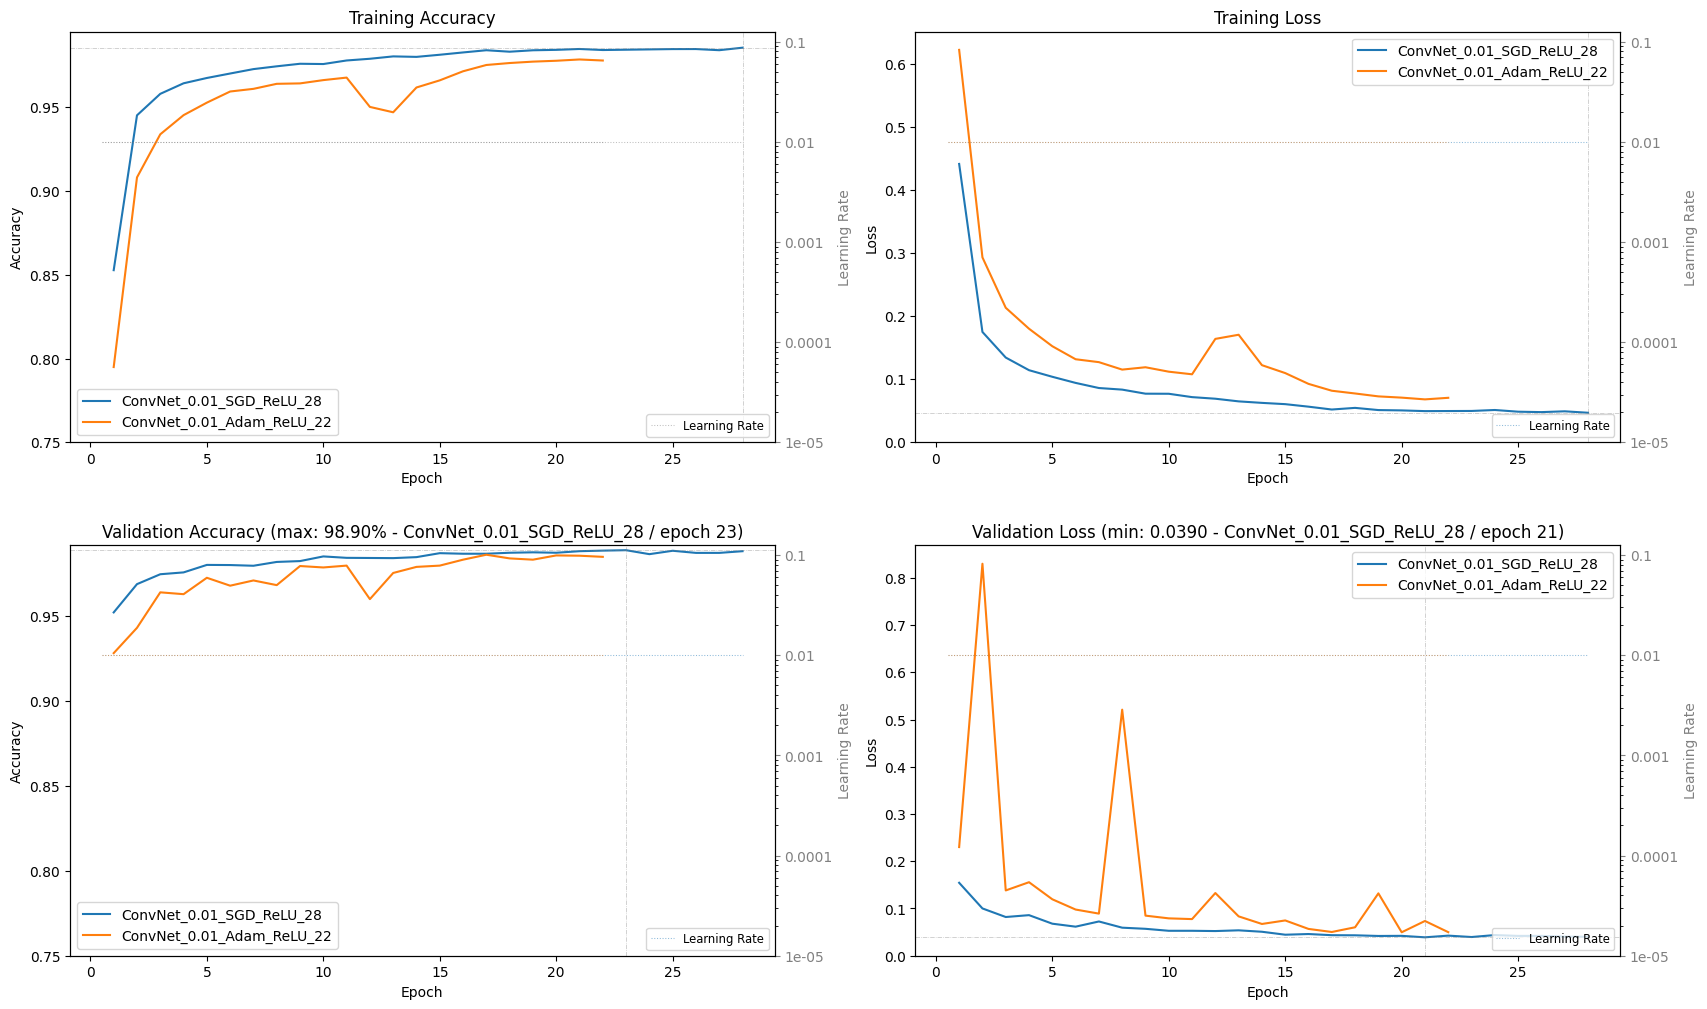

In [ ]:
plot_metrics()

Testing progress:   0%|          | 0/79 [00:00<?, ?it/s]

                           Test accuracy: 98.82%


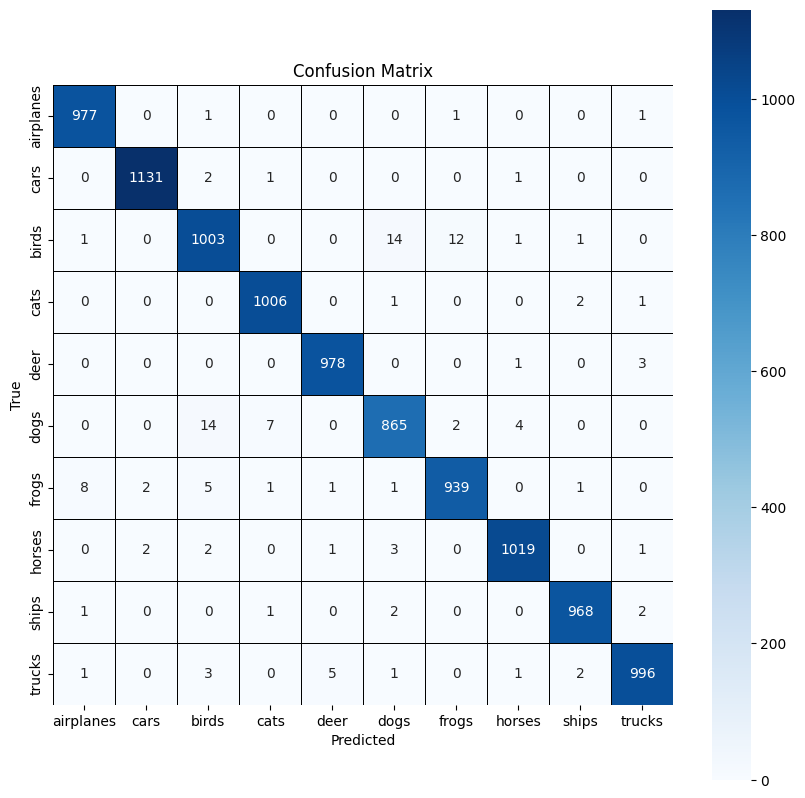

Classification Report:

              precision    recall  f1-score   support

   airplanes       0.99      1.00      0.99       980
        cars       1.00      1.00      1.00      1135
       birds       0.97      0.97      0.97      1032
        cats       0.99      1.00      0.99      1010
        deer       0.99      1.00      0.99       982
        dogs       0.98      0.97      0.97       892
       frogs       0.98      0.98      0.98       958
      horses       0.99      0.99      0.99      1028
       ships       0.99      0.99      0.99       974
      trucks       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

tensor([[5.9991e-09, 3.1278e-06, 1.8719e-07,  ..., 1.0000e+00, 2.4122e-09,
         1.7914e-07],
        [1.4149e-06, 3.0009e-06, 9.9986e-01,  ..., 3.4809e-07, 2.3592e-08,
         2.6081e-08],
        [1.4969e-08, 1.

In [ ]:
# Testing the best model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the saved model
model_path = os.path.join(mount_point, project_folder, f'best_model.pth')

# Set the model to evaluation mode
for model_dict in model_list:

    model_name = model_dict["name"]
    model_class = model_dict["model"]

model = model_class(nn.ReLU()).to(device)
model.eval()

# Load the model weights
if device.type == 'cuda':
    model.load_state_dict(torch.load(model_path))
else:
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

all_preds = []
all_labels = []

softmax_scores = []
image_names = []

test_progress_bar = tqdm(dataloaders['test'], desc='Testing progress')

for inputs, labels, paths in test_progress_bar:
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(inputs)
        softmax = torch.nn.functional.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())
    softmax_scores.append(softmax.cpu())
    image_names.extend([p.item() for p in paths.flatten()])  # Convert tensor to string and flatten

    # Update progress bar
    test_progress_bar.set_postfix(acc=torch.sum(preds == labels.data))

accuracy = accuracy_score(all_labels, all_preds)
print(f'                           Test accuracy: {accuracy * 100:.2f}%')

softmax_scores = torch.cat(softmax_scores)
#image_names = [os.path.splitext(os.path.basename(p))[0] for p in image_names]

# Plotting confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True, linewidths=0.5, linecolor='black', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
report = classification_report(all_labels, all_preds, target_names=class_names)
print('Classification Report:\n')
print(report)

print(softmax_scores)

# Saving softmax scores
softmax_scores_path = os.path.join(mount_point, project_folder, softmax_folder, 'softmax_scores.npy')

if not os.path.exists(softmax_scores_path):
    np.save(softmax_scores_path, softmax_scores)
    print(f'\nSoftmax scores saved to {softmax_scores_path}')
else:
    print(f'\nSoftmax scores already stored in {softmax_scores_path}')

**Transfer Learning on SVHN**

In [ ]:
# Set the random seed for reproducibility
np.random.seed(42)

# Set the project folder
mount_point = '/content/drive/'
data_folder = '/content/data'

if not os.path.exists(mount_point):
    drive.mount(mount_point)
else:
    print(f"Drive is already mounted at {mount_point}")

os.chdir(os.path.join(mount_point))

# Delete existing data folders
if os.path.exists(data_folder):
    shutil.rmtree(data_folder)

# Create the data folder if it doesn't exist
if not os.path.exists(data_folder):
    os.makedirs(data_folder)

# Create the 'project' folder on Google Drive if it doesn't exist
project_folder = os.path.join(mount_point, 'MyDrive/D7047E/SVHN/')
if not os.path.exists(project_folder):
    os.makedirs(project_folder)
    print(f"\nProject folder created at {project_folder}")

# Create the 'accuracy' folder in the project folder on Google Drive if it doesn't exist
accuracy_folder = os.path.join(mount_point, project_folder, 'accuracy')
if not os.path.exists(accuracy_folder):
    os.makedirs(accuracy_folder)
    print(f"\naccuracy folder created at {accuracy_folder}")

# Create the 'softmax' folder in the project folder on Google Drive if it doesn't exist
softmax_folder = os.path.join(mount_point, project_folder, 'softmax')
if not os.path.exists(softmax_folder):
    os.makedirs(softmax_folder)
    print(f"\nsoftmax folder created at {softmax_folder}")

# Create the 'logs' folder in the project folder on Google Drive if it doesn't exist
logs_folder = os.path.join(mount_point, project_folder, 'logs')
if not os.path.exists(logs_folder):
    os.makedirs(logs_folder)
    print(f"\nlogs folder created at {logs_folder}")

# Create the 'checkpoints' folder in the project folder on Google Drive if it doesn't exist
checkpoint_folder = os.path.join(mount_point, project_folder, 'checkpoint')
if not os.path.exists(checkpoint_folder):
    os.makedirs(checkpoint_folder)
    print(f"\nCheckpoints folder created at {checkpoint_folder}")

os.chdir('/content/')

if not os.path.exists(data_folder):
    num_files = 0
else:
    num_files = 0
    for root, dirs, files in os.walk(data_folder):
        num_files += len(files)

print(f'\nThere are {num_files} files in the destination folder: {data_folder}\n')

# Data transforms
transform = {
    'train': transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize(32),
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)) # MNIST
    ]),
    'valid': transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize(32),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)) # MNIST
    ]),
    'test': transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize(32),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)) # MNIST
    ]),
    'visualization': transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize(32),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
    ])
}

# Download and extract SVHN datasets
trainset = datasets.SVHN(root=data_folder, split='train', transform=transform['train'], download=True)
testset  = datasets.SVHN(root=data_folder, split='test', transform=transform['test'], download=True)

print("\nSVHN dataset downloaded and extracted successfully.")

# Split trainset into validation and training using stratified sampling
trainset.labels = np.array(trainset.labels)
train_idx, val_idx = train_test_split(np.arange(len(trainset.labels)),
                                  test_size=0.2,
                                  stratify=trainset.labels,
                                  random_state=42)

train_set = Subset(trainset, train_idx)
val_set = Subset(trainset, val_idx)

# Verify splits are disjoint
assert set(train_idx).isdisjoint(set(val_idx)), "There are common elements between the training and validation splits"

# Create dataloaders
batch_size = 128
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

dataloaders = {'train': train_loader, 'valid': val_loader, 'test': test_loader}

# Class labels for MNIST & SVHN dataset

#class_names = list(range(10))
class_names = [str(i) for i in range(10)]

# Save metrics to pickle files
pickle_files = [
    "SVHN_all_train_accuracies.pickle",
    "SVHN_all_train_losses.pickle",
    "SVHN_all_val_accuracies.pickle",
    "SVHN_all_val_losses.pickle",
    "SVHN_all_learning_rates.pickle",]

Mounted at /content/drive/

There are 0 files in the destination folder: /content/data



  0%|          | 0/182040794 [00:00<?, ?it/s]

  0%|          | 0/64275384 [00:00<?, ?it/s]


SVHN dataset downloaded and extracted successfully.


Testing progress:   0%|          | 0/204 [00:00<?, ?it/s]

                           Test accuracy: 7.13%


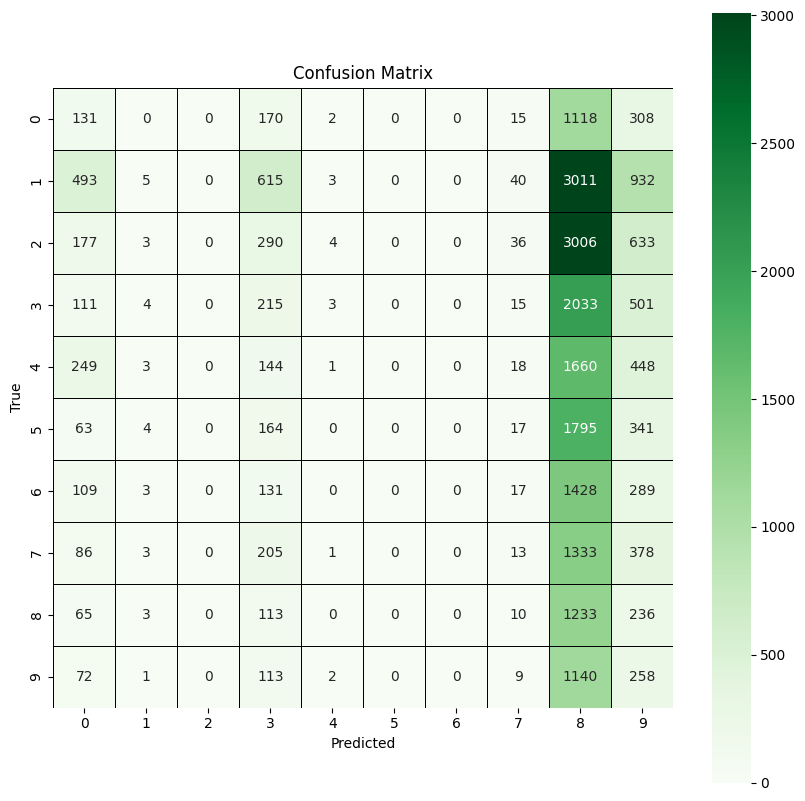

Classification Report:

              precision    recall  f1-score   support

           0       0.08      0.08      0.08      1744
           1       0.17      0.00      0.00      5099
           2       0.00      0.00      0.00      4149
           3       0.10      0.07      0.09      2882
           4       0.06      0.00      0.00      2523
           5       0.00      0.00      0.00      2384
           6       0.00      0.00      0.00      1977
           7       0.07      0.01      0.01      2019
           8       0.07      0.74      0.13      1660
           9       0.06      0.16      0.09      1595

    accuracy                           0.07     26032
   macro avg       0.06      0.11      0.04     26032
weighted avg       0.07      0.07      0.03     26032



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Testing the best ConvNet model on SVHN 'as is'

class ConvNet(nn.Module):
    def __init__(self, activation_function=nn.ReLU()):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1) #modified for greyscale
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25)

        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(0.25)

        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.bn5 = nn.BatchNorm1d(512)
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 10)

        self.activation_function = activation_function

    def forward(self, x):
        x = self.bn1(self.activation_function(self.conv1(x)))
        x = self.bn2(self.activation_function(self.conv2(x)))
        x = self.dropout1(self.pool1(x))

        x = self.bn3(self.activation_function(self.conv3(x)))
        x = self.bn4(self.activation_function(self.conv4(x)))
        x = self.dropout2(self.pool2(x))

        x = x.view(-1, 64 * 8 * 8)
        x = self.bn5(self.activation_function(self.fc1(x)))
        x = self.dropout3(x)
        x = self.fc2(x)

        return x

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ConvNet().to(device)

# Load the saved model
model_path = os.path.join(mount_point, project_folder, f'best_model.pth')

# Set the model to evaluation mode
model.eval()

# Load the model weights
if device.type == 'cuda':
    model.load_state_dict(torch.load(model_path))
else:
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

all_preds = []
all_labels = []

softmax_scores = []
image_names = []

test_progress_bar = tqdm(dataloaders['test'], desc='Testing progress')

for inputs, labels in test_progress_bar:
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(inputs)
        softmax = torch.nn.functional.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())
    softmax_scores.append(softmax.cpu())
    #image_names.extend([p.item() for p in paths.flatten()])  # Convert tensor to string and flatten

    # Update progress bar
    test_progress_bar.set_postfix(acc=torch.sum(preds == labels.data))

accuracy = accuracy_score(all_labels, all_preds)
print(f'                           Test accuracy: {accuracy * 100:.2f}%')

softmax_scores = torch.cat(softmax_scores)
#image_names = [os.path.splitext(os.path.basename(p))[0] for p in image_names]

# Plotting confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', square=True, linewidths=0.5, linecolor='black', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
report = classification_report(all_labels, all_preds, target_names=class_names)
print('Classification Report:\n')
print(report)

In [ ]:
# Define the custom CNN architecture class
class ConvNet(nn.Module):
    def __init__(self, activation_function=nn.ReLU()):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1) #modified for greyscale
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25)

        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(0.25)

        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.bn5 = nn.BatchNorm1d(512)
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 10)

        self.activation_function = activation_function

    def forward(self, x):
        x = self.bn1(self.activation_function(self.conv1(x)))
        x = self.bn2(self.activation_function(self.conv2(x)))
        x = self.dropout1(self.pool1(x))

        x = self.bn3(self.activation_function(self.conv3(x)))
        x = self.bn4(self.activation_function(self.conv4(x)))
        x = self.dropout2(self.pool2(x))

        x = x.view(-1, 64 * 8 * 8)
        x = self.bn5(self.activation_function(self.fc1(x)))
        x = self.dropout3(x)
        x = self.fc2(x)

        return x

def convert_to_cpu(tensor_list):
    return [tensor.cpu().numpy() if isinstance(tensor, torch.Tensor) else tensor for tensor in tensor_list]


def save_dicts_to_files(file_prefix, data_dicts, accuracy_folder):
    for data_dict, file in zip(data_dicts, pickle_files):
        file_name = os.path.join(accuracy_folder, f"{file[:-7]}{file_prefix}.pickle")
        with open(file_name, "wb") as handle:
            converted_dict = {k: [t.cpu().numpy() if isinstance(t, torch.Tensor) else t for t in v] for k, v in data_dict.items()}
            pickle.dump(converted_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)


def load_dicts_from_files(pickle_files, accuracy_folder):
    loaded_dicts = []
    for file in pickle_files:
        file_name = os.path.join(accuracy_folder, file)
        with open(file_name, "rb") as handle:
            data_dict = pickle.load(handle)

            # Convert to CPU
            data_dict_cpu = {k: convert_to_cpu(v) for k, v in data_dict.items()}
            loaded_dicts.append(data_dict_cpu)
    return loaded_dicts


def activation_name(activation_func):
    name = str(activation_func)
    if "Tanh" in name:
        return "Tanh"
    elif "LeakyReLU" in name:
        return "LeakyReLU"
    elif ".ReLU" in name:
        return "ReLU"
    else:
        return name


def latest_checkpoint(checkpoint_folder):
    checkpoint_files = [f for f in os.listdir(checkpoint_folder) if f.endswith('.pth')]
    if not checkpoint_files:
        return None

    # Extract epoch numbers from file names
    epoch_numbers = [int(re.search(r'e(\d+)', f).group(1)) for f in checkpoint_files]

    # Find the file with the highest epoch number
    latest_epoch = max(epoch_numbers)
    latest_checkpoint_file = f'model_checkpoint_e{latest_epoch}.pth'

    return os.path.join(checkpoint_folder, latest_checkpoint_file)


def train_and_evaluate(model_list, criterion, activation_functions, lr, optimizers, epochs, best_val_acc, best_model_params, metric, lr_patience, early_stopping_patience, tensorboard_log, tensorboard_active, saving_frequency, freeze_layers, layers):

    for model_dict in model_list:

        model_name = model_dict["name"]
        model_class = model_dict["model"]

        best_val_acc = 0.0
        best_model_params = None

        # Initialize dictionaries to store losses and accuracies for each hyperparameter
        all_train_losses = {}
        all_train_accuracies = {}
        all_val_losses = {}
        all_val_accuracies = {}
        all_learning_rates = {}

        data_dicts = [all_train_accuracies, all_train_losses, all_val_accuracies, all_val_losses, all_learning_rates]

        best_model = None

        if tensorboard_active:
            %tensorboard --logdir {os.path.join(mount_point, project_folder, 'logs')}
        if tensorboard_log:
            writer = SummaryWriter(os.path.join(mount_point, project_folder, 'logs', f'{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}'))

        # Check for the latest checkpoint
        latest_checkpoint_path = latest_checkpoint(os.path.join(mount_point, project_folder, checkpoint_folder))

        start_epoch = 0
        if latest_checkpoint_path:
            user_input = input(f'Latest checkpoint found: {latest_checkpoint_path}. Do you want to resume training from this epoch? (y/n): ')

            if user_input.lower() == 'y':
                checkpoint = torch.load(latest_checkpoint_path)
                model.load_state_dict(checkpoint['model_state_dict'])

                # Get the optimizer type from the checkpoint
                optimizer_type = checkpoint['optimizer_type']

                # Initialize the optimizer using the optimizer type from the checkpoint
                optimizer = optimizers[optimizer_type](model.parameters(), lr=lr)
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

                scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
                start_epoch = checkpoint['epoch'] + 1
                best_val_metric = checkpoint['best_val_metric']

        for opt in optimizers:

            for af in activation_functions:

                # Create a new model for each hyperparameter combination
                model = model_class(activation_function=af()).to(device)

                # Freeze the layers
                if freeze_layers:
                    for name, param in model.named_parameters():
                        if layers not in name:
                            param.requires_grad = False


                # Initialize the model and criterion
                initial_model_state = deepcopy(model.state_dict())
                initial_criterion = deepcopy(criterion)

                # Initialize the optimizer based on the selected type
                if opt == 'SGD':
                    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
                elif opt == 'Adam':
                    optimizer = optim.Adam(model.parameters(), lr=lr)

                print(f'\n\n\nTraining model {model_name} with learning rate: {lr}, optimizer: {opt} and activation function: {activation_name(af)} \n\n')

                # Initialize the learning rate scheduler
                scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=lr_patience, verbose=True)

                #for epoch in range(start_epoch, epochs):

                # Initialize lists to store loss and accuracy values
                train_losses = []
                train_accuracies = []
                val_losses = []
                val_accuracies = []
                learning_rates = []

                # Define early stopping parameters
                epochs_since_best = 0
                best_val_metric = None

                for epoch in range(epochs):
                    print(f'Epoch {epoch + 1}/{epochs}')
                    print('-' * 10)

                    hp = f'{model_name}_{lr}_{opt}_{activation_name(af)}_{epoch + 1}'

                    for phase in ['train', 'valid']:
                        if phase == 'train':
                            model.train()
                        else:
                            model.eval()

                        running_loss = 0.0
                        running_corrects = 0
                        num_samples = 0

                        progress_bar = tqdm(dataloaders[phase], desc=f'{phase} progress')
                        for inputs, labels in progress_bar:
                            inputs = inputs.to(device)
                            labels = labels.to(device)
                            optimizer.zero_grad()

                            # Forward pass and calculate the loss
                            with torch.set_grad_enabled(phase == 'train'):
                                outputs = model(inputs)
                                _, preds = torch.max(outputs, 1)
                                loss = criterion(outputs, labels)

                                # Backward pass and optimize the weights
                                if phase == 'train':
                                    loss.backward()
                                    optimizer.step()

                            running_loss += loss.item() * inputs.size(0)
                            running_corrects += torch.sum(preds == labels.data)
                            num_samples += inputs.size(0)

                            # Update the progress bar
                            progress_bar.set_postfix(loss=loss.item(), acc=running_corrects.double() / num_samples, refresh=True)

                        epoch_loss = running_loss / num_samples
                        epoch_acc = running_corrects.double() / num_samples

                        print(f'                      loss: {epoch_loss:.4f} accuracy: {epoch_acc * 100:.2f}%')

                        if phase == 'train':
                            train_losses.append(epoch_loss)
                            train_accuracies.append(epoch_acc)

                            # Tensorboard
                            if tensorboard_log:
                                writer.add_scalar(f'Training loss_{hp}', epoch_loss, epoch)
                                writer.add_scalar(f'Training accuracy_{hp}', epoch_acc, epoch)

                        else:
                            val_losses.append(epoch_loss)
                            val_accuracies.append(epoch_acc)

                            # Tensorboard
                            if tensorboard_log:
                                writer.add_scalar(f'Validation loss_{hp}', epoch_loss, epoch)
                                writer.add_scalar(f'Validation accuracy_{hp}', epoch_acc, epoch)

                            # Update the learning rate based on the validation accuracy
                            scheduler.step(epoch_acc)

                            # Save the current learning rate
                            lr = optimizer.param_groups[0]['lr']
                            learning_rates.append(lr)

                            # Save the current model state every 'x' epochs
                            if (epoch + 1) % saving_frequency == 0:
                                model_save_name = f'model_checkpoint_e{epoch+1}.pth'
                                model_save_path = os.path.join(mount_point, project_folder, checkpoint_folder, model_save_name)
                                print(f'\nSaving checkpoint for epoch {epoch+1} at {model_save_path}\n')
                                torch.save({
                                    'epoch': epoch,
                                    'model_state_dict': model.state_dict(),
                                    'optimizer_state_dict': optimizer.state_dict(),
                                    'scheduler_state_dict': scheduler.state_dict(),
                                    'best_val_metric': best_val_metric,
                                    'optimizer_type': opt,
                                    'model_name': model_name
                                }, model_save_path)

                                checkpoint_paths = sorted(glob.glob(os.path.join(mount_point, project_folder, checkpoint_folder, '*.pth')), key=os.path.getctime)
                                if len(checkpoint_paths) > 2:
                                    for path in checkpoint_paths[:-2]:
                                        os.unlink(path)


                    # Choose the metric based on the 'metric' parameter
                    if metric == 'accuracy':
                        val_metric = epoch_acc
                        mode = 'max'
                    elif metric == 'loss':
                        val_metric = epoch_loss
                        mode = 'min'

                    # Update best validation metric and reset the counter
                    if best_val_metric is None or (mode == 'max' and val_metric > best_val_metric) or (mode == 'min' and val_metric < best_val_metric):
                        best_val_metric = val_metric
                        epochs_since_best = 0
                    else:
                        # Increment the counter if there is no improvement
                        epochs_since_best += 1

                    # Check if early stopping condition is met
                    if epochs_since_best >= early_stopping_patience:
                        print(f"\nEarly stopping triggered at epoch {epoch + 1}. No significant improvement in the validation metric for {early_stopping_patience} epochs.")
                        break


                # Save the losses and accuracies for the current setting
                all_train_losses[hp] = train_losses
                all_train_accuracies[hp] = train_accuracies
                all_val_losses[hp] = val_losses
                all_val_accuracies[hp] = val_accuracies
                all_learning_rates[hp] = learning_rates

                current_val_acc = max(val_accuracies)
                current_val_loss = min(val_losses)
                max_val_acc_epoch = val_accuracies.index(current_val_acc) + 1

                # Update the best model if the current validation accuracy is better
                if current_val_acc > best_val_acc:
                    best_val_acc = current_val_acc
                    rel_val_loss = current_val_loss
                    best_model = model
                    best_model_params = {
                        'lr': lr,
                        'af': {activation_name(af)},
                        'optimizer': opt,
                        'model_state': model.state_dict(),
                        'val_acc_epoch': max_val_acc_epoch  #save the epoch when the best validation accuracy is achieved
                    }

                    table = [["Model", model_name],
                            ["Best Validation Accuracy", f"{best_val_acc * 100:.2f}%"],
                            ["Validation Loss", f"{rel_val_loss:.4f}"],
                            ["Learning Rate", best_model_params["lr"]],
                            ["Optimizer", best_model_params["optimizer"]],
                            ["Activation", activation_name(af)],
                            ["Epoch", best_model_params["val_acc_epoch"]]]

                    print('\n', tabulate(table, tablefmt="simple"))

                    # Hyperparameter information
                    file_name_prefix = f'{model_name}_acc{best_val_acc:.4f}_lr{best_model_params["lr"]}_{best_model_params["optimizer"]}_epoch{best_model_params["val_acc_epoch"]}_{activation_name(af)}'

                    if best_model is not None:
                        # Save the best model with hyperparameter information
                        model_save_name = f'model__{file_name_prefix}.pth'
                        model_save_path = os.path.join(mount_point, project_folder, model_save_name)
                        torch.save(best_model_params['model_state'], model_save_path)
                        print(f'\nBest model saved to {model_save_path}')

                        # Save the best model as 'best_model.pth'
                        model_save_name = f'best_model.pth'
                        model_save_path = os.path.join(mount_point, project_folder, model_save_name)
                        torch.save(best_model_params['model_state'], model_save_path)
                        print(f'\nBest model also saved as "best_model.pth"\n\n')


        # Close TensorBoard writer
        if tensorboard_log:
            writer.close()

        # Save with the prefix
        save_dicts_to_files(file_name_prefix, data_dicts, accuracy_folder)

        # Save to the base files
        save_dicts_to_files('', data_dicts, accuracy_folder)

    return best_model

In [ ]:
# model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

optimizers = {
    'SGD': torch.optim.SGD,
}
model_list = [
    {"name": "ConvNet", "model": ConvNet},
]
activation_functions = [nn.ReLU] # [nn.LeakyReLU, nn.Tanh]
lr = 0.01
epochs = 100

lr_patience = 2 # reduce learning rate by factor 0.1 if the validation performance doesn't improve after 'x' number of epochs
early_stopping_patience = 5 # stop training if the validation performance doesn't improve after 'x' number of epochs
metric = 'accuracy' # to maximize the 'accuracy'
#metric = 'loss'  # to minimize the 'loss'
criterion = nn.CrossEntropyLoss()

best_val_acc = float('-inf')
best_model_params = None
tensorboard_active = False
tensorboard_log = False
saving_frequency = 50
freeze_layers = True
layers = 'fc'

train_and_evaluate(model_list, criterion, activation_functions, lr, optimizers, epochs, best_val_acc, best_model_params, metric, lr_patience, early_stopping_patience, tensorboard_log, tensorboard_active, saving_frequency, freeze_layers, layers)




Training model ConvNet with learning rate: 0.01, optimizer: SGD and activation function: ReLU 


Epoch 1/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 2.3006 accuracy: 20.32%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 5.5102 accuracy: 24.32%
Epoch 2/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 2.1404 accuracy: 26.33%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 5.2662 accuracy: 28.39%
Epoch 3/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 2.0752 accuracy: 28.75%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 5.1447 accuracy: 31.52%
Epoch 4/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 2.0245 accuracy: 30.00%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 4.9543 accuracy: 34.98%
Epoch 5/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.9952 accuracy: 31.35%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 5.0953 accuracy: 36.20%
Epoch 6/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.9653 accuracy: 32.28%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 6.2698 accuracy: 37.18%
Epoch 7/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.9387 accuracy: 33.14%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 8.8542 accuracy: 34.89%
Epoch 8/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.9100 accuracy: 33.68%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 6.6489 accuracy: 37.09%
Epoch 9/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.9017 accuracy: 33.99%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 7.5301 accuracy: 40.53%
Epoch 10/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.8763 accuracy: 34.80%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 6.2955 accuracy: 41.41%
Epoch 11/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.8683 accuracy: 35.28%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 6.2574 accuracy: 42.26%
Epoch 12/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.8542 accuracy: 35.82%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 5.6695 accuracy: 43.33%
Epoch 13/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.8357 accuracy: 36.34%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 5.5106 accuracy: 42.84%
Epoch 14/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.8291 accuracy: 36.63%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 6.5047 accuracy: 43.54%
Epoch 15/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.8145 accuracy: 37.16%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 5.8623 accuracy: 43.99%
Epoch 16/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.7989 accuracy: 37.64%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 5.2110 accuracy: 44.50%
Epoch 17/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.7961 accuracy: 37.83%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 5.8039 accuracy: 45.67%
Epoch 18/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.7831 accuracy: 38.31%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 5.9732 accuracy: 44.93%
Epoch 19/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.7702 accuracy: 38.46%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 6.1577 accuracy: 45.97%
Epoch 20/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.7620 accuracy: 38.78%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 5.7076 accuracy: 45.23%
Epoch 21/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.7539 accuracy: 39.47%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 6.2279 accuracy: 45.26%
Epoch 22/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.7472 accuracy: 39.48%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 6.2726 accuracy: 46.02%
Epoch 23/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.7471 accuracy: 39.76%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 7.5545 accuracy: 46.69%
Epoch 24/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.7351 accuracy: 39.79%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 7.2359 accuracy: 48.01%
Epoch 25/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.7318 accuracy: 40.18%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 6.5209 accuracy: 48.00%
Epoch 26/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.7367 accuracy: 39.73%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 7.3103 accuracy: 47.19%
Epoch 27/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.7250 accuracy: 40.31%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 7.5182 accuracy: 48.23%
Epoch 28/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.7200 accuracy: 40.84%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 6.6918 accuracy: 47.17%
Epoch 29/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.7139 accuracy: 40.92%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 8.0101 accuracy: 48.71%
Epoch 30/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.7071 accuracy: 40.77%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 8.0175 accuracy: 48.05%
Epoch 31/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.6987 accuracy: 41.22%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 7.4382 accuracy: 48.08%
Epoch 32/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.7033 accuracy: 41.18%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 8.2223 accuracy: 49.26%
Epoch 33/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.6975 accuracy: 41.26%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 8.1219 accuracy: 48.93%
Epoch 34/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.6977 accuracy: 41.28%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 7.6624 accuracy: 48.46%
Epoch 35/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.6825 accuracy: 41.91%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 8.1305 accuracy: 50.07%
Epoch 36/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.6835 accuracy: 41.92%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 8.1483 accuracy: 48.81%
Epoch 37/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.6754 accuracy: 42.11%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 7.5411 accuracy: 49.80%
Epoch 38/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.6734 accuracy: 42.07%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 8.1862 accuracy: 49.88%
Epoch 00038: reducing learning rate of group 0 to 1.0000e-03.
Epoch 39/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.6339 accuracy: 43.74%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 8.0484 accuracy: 52.54%
Epoch 40/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.6098 accuracy: 44.76%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 7.3089 accuracy: 53.65%
Epoch 41/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.5944 accuracy: 45.12%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 8.1386 accuracy: 53.40%
Epoch 42/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.5948 accuracy: 45.59%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 7.2862 accuracy: 53.54%
Epoch 43/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.5944 accuracy: 45.26%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 7.5399 accuracy: 53.62%
Epoch 00043: reducing learning rate of group 0 to 1.0000e-04.
Epoch 44/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.5903 accuracy: 45.65%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 7.5999 accuracy: 53.69%
Epoch 45/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.5862 accuracy: 45.54%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 7.9887 accuracy: 53.95%
Epoch 46/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.5894 accuracy: 45.53%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 7.2935 accuracy: 54.49%
Epoch 47/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.5846 accuracy: 45.55%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 7.3976 accuracy: 53.71%
Epoch 48/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.5921 accuracy: 45.55%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 7.8552 accuracy: 53.54%
Epoch 49/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.5861 accuracy: 45.53%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 7.1529 accuracy: 53.99%
Epoch 00049: reducing learning rate of group 0 to 1.0000e-05.
Epoch 50/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.5851 accuracy: 45.81%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 7.4644 accuracy: 53.17%

Saving checkpoint for epoch 50 at /content/drive/MyDrive/D7047E/SVHN/checkpoint/model_checkpoint_e50.pth

Epoch 51/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.5876 accuracy: 45.69%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 7.0660 accuracy: 53.62%

Early stopping triggered at epoch 51. No significant improvement in the validation metric for 5 epochs.

 ------------------------  -------
Model                     ConvNet
Best Validation Accuracy  54.49%
Validation Loss           4.9543
Learning Rate             1e-05
Optimizer                 SGD
Activation                ReLU
Epoch                     46
------------------------  -------

Best model saved to /content/drive/MyDrive/D7047E/SVHN/model__ConvNet_acc0.5449_lr1e-05_SGD_epoch46_ReLU.pth

Best model also saved as "best_model.pth"




ConvNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (

In [ ]:
# Define the custom CNN architecture class
class ConvNet(nn.Module):
    def __init__(self, activation_function=nn.ReLU()):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1) #modified for greyscale
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25)

        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(0.25)

        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.bn5 = nn.BatchNorm1d(512)
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 10)

        self.activation_function = activation_function

    def forward(self, x):
        x = self.bn1(self.activation_function(self.conv1(x)))
        x = self.bn2(self.activation_function(self.conv2(x)))
        x = self.dropout1(self.pool1(x))

        x = self.bn3(self.activation_function(self.conv3(x)))
        x = self.bn4(self.activation_function(self.conv4(x)))
        x = self.dropout2(self.pool2(x))

        x = x.view(-1, 64 * 8 * 8)
        x = self.bn5(self.activation_function(self.fc1(x)))
        x = self.dropout3(x)
        x = self.fc2(x)

        return x

def convert_to_cpu(tensor_list):
    return [tensor.cpu().numpy() if isinstance(tensor, torch.Tensor) else tensor for tensor in tensor_list]


def save_dicts_to_files(file_prefix, data_dicts, accuracy_folder):
    for data_dict, file in zip(data_dicts, pickle_files):
        file_name = os.path.join(accuracy_folder, f"{file[:-7]}{file_prefix}.pickle")
        with open(file_name, "wb") as handle:
            converted_dict = {k: [t.cpu().numpy() if isinstance(t, torch.Tensor) else t for t in v] for k, v in data_dict.items()}
            pickle.dump(converted_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)


def load_dicts_from_files(pickle_files, accuracy_folder):
    loaded_dicts = []
    for file in pickle_files:
        file_name = os.path.join(accuracy_folder, file)
        with open(file_name, "rb") as handle:
            data_dict = pickle.load(handle)

            # Convert to CPU
            data_dict_cpu = {k: convert_to_cpu(v) for k, v in data_dict.items()}
            loaded_dicts.append(data_dict_cpu)
    return loaded_dicts


def activation_name(activation_func):
    name = str(activation_func)
    if "Tanh" in name:
        return "Tanh"
    elif "LeakyReLU" in name:
        return "LeakyReLU"
    elif ".ReLU" in name:
        return "ReLU"
    else:
        return name


def latest_checkpoint(checkpoint_folder):
    checkpoint_files = [f for f in os.listdir(checkpoint_folder) if f.endswith('.pth')]
    if not checkpoint_files:
        return None

    # Extract epoch numbers from file names
    epoch_numbers = [int(re.search(r'e(\d+)', f).group(1)) for f in checkpoint_files]

    # Find the file with the highest epoch number
    latest_epoch = max(epoch_numbers)
    latest_checkpoint_file = f'model_checkpoint_e{latest_epoch}.pth'

    return os.path.join(checkpoint_folder, latest_checkpoint_file)


def train_and_evaluate(model_list, criterion, activation_functions, lr, optimizers, epochs, best_val_acc, best_model_params, metric, lr_patience, early_stopping_patience, tensorboard_log, tensorboard_active, saving_frequency, freeze_layers, layers):

    for model_dict in model_list:

        model_name = model_dict["name"]
        model_class = model_dict["model"]

        best_val_acc = 0.0
        best_model_params = None

        # Initialize dictionaries to store losses and accuracies for each hyperparameter
        all_train_losses = {}
        all_train_accuracies = {}
        all_val_losses = {}
        all_val_accuracies = {}
        all_learning_rates = {}

        data_dicts = [all_train_accuracies, all_train_losses, all_val_accuracies, all_val_losses, all_learning_rates]

        best_model = None

        if tensorboard_active:
            %tensorboard --logdir {os.path.join(mount_point, project_folder, 'logs')}
        if tensorboard_log:
            writer = SummaryWriter(os.path.join(mount_point, project_folder, 'logs', f'{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}'))

        # Check for the latest checkpoint
        latest_checkpoint_path = latest_checkpoint(os.path.join(mount_point, project_folder, checkpoint_folder))

        start_epoch = 0
        if latest_checkpoint_path:
            user_input = input(f'Latest checkpoint found: {latest_checkpoint_path}. Do you want to resume training from this epoch? (y/n): ')

            if user_input.lower() == 'y':
                checkpoint = torch.load(latest_checkpoint_path)
                model.load_state_dict(checkpoint['model_state_dict'])

                # Get the optimizer type from the checkpoint
                optimizer_type = checkpoint['optimizer_type']

                # Initialize the optimizer using the optimizer type from the checkpoint
                optimizer = optimizers[optimizer_type](model.parameters(), lr=lr)
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

                scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
                start_epoch = checkpoint['epoch'] + 1
                best_val_metric = checkpoint['best_val_metric']

        for opt in optimizers:

            for af in activation_functions:

                # Create a new model for each hyperparameter combination
                model = model_class(activation_function=af()).to(device)

                # Freeze the layers
                if freeze_layers:
                    for name, param in model.named_parameters():
                        if name.split('.')[0] in layers:
                            param.requires_grad = False

                # Initialize the model and criterion
                initial_model_state = deepcopy(model.state_dict())
                initial_criterion = deepcopy(criterion)

                # Initialize the optimizer based on the selected type
                if opt == 'SGD':
                    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
                elif opt == 'Adam':
                    optimizer = optim.Adam(model.parameters(), lr=lr)

                print(f'\n\n\nTraining model {model_name} with learning rate: {lr}, optimizer: {opt} and activation function: {activation_name(af)} \n\n')

                # Initialize the learning rate scheduler
                scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=lr_patience, verbose=True)

                #for epoch in range(start_epoch, epochs):

                # Initialize lists to store loss and accuracy values
                train_losses = []
                train_accuracies = []
                val_losses = []
                val_accuracies = []
                learning_rates = []

                # Define early stopping parameters
                epochs_since_best = 0
                best_val_metric = None

                for epoch in range(epochs):
                    print(f'Epoch {epoch + 1}/{epochs}')
                    print('-' * 10)

                    hp = f'{model_name}_{lr}_{opt}_{activation_name(af)}_{epoch + 1}'

                    for phase in ['train', 'valid']:
                        if phase == 'train':
                            model.train()
                        else:
                            model.eval()

                        running_loss = 0.0
                        running_corrects = 0
                        num_samples = 0

                        progress_bar = tqdm(dataloaders[phase], desc=f'{phase} progress')
                        for inputs, labels in progress_bar:
                            inputs = inputs.to(device)
                            labels = labels.to(device)
                            optimizer.zero_grad()

                            # Forward pass and calculate the loss
                            with torch.set_grad_enabled(phase == 'train'):
                                outputs = model(inputs)
                                _, preds = torch.max(outputs, 1)
                                loss = criterion(outputs, labels)

                                # Backward pass and optimize the weights
                                if phase == 'train':
                                    loss.backward()
                                    optimizer.step()

                            running_loss += loss.item() * inputs.size(0)
                            running_corrects += torch.sum(preds == labels.data)
                            num_samples += inputs.size(0)

                            # Update the progress bar
                            progress_bar.set_postfix(loss=loss.item(), acc=running_corrects.double() / num_samples, refresh=True)

                        epoch_loss = running_loss / num_samples
                        epoch_acc = running_corrects.double() / num_samples

                        print(f'                      loss: {epoch_loss:.4f} accuracy: {epoch_acc * 100:.2f}%')

                        if phase == 'train':
                            train_losses.append(epoch_loss)
                            train_accuracies.append(epoch_acc)

                            # Tensorboard
                            if tensorboard_log:
                                writer.add_scalar(f'Training loss_{hp}', epoch_loss, epoch)
                                writer.add_scalar(f'Training accuracy_{hp}', epoch_acc, epoch)

                        else:
                            val_losses.append(epoch_loss)
                            val_accuracies.append(epoch_acc)

                            # Tensorboard
                            if tensorboard_log:
                                writer.add_scalar(f'Validation loss_{hp}', epoch_loss, epoch)
                                writer.add_scalar(f'Validation accuracy_{hp}', epoch_acc, epoch)

                            # Update the learning rate based on the validation accuracy
                            scheduler.step(epoch_acc)

                            # Save the current learning rate
                            lr = optimizer.param_groups[0]['lr']
                            learning_rates.append(lr)

                            # Save the current model state every 'x' epochs
                            if (epoch + 1) % saving_frequency == 0:
                                model_save_name = f'model_checkpoint_e{epoch+1}.pth'
                                model_save_path = os.path.join(mount_point, project_folder, checkpoint_folder, model_save_name)
                                print(f'\nSaving checkpoint for epoch {epoch+1} at {model_save_path}\n')
                                torch.save({
                                    'epoch': epoch,
                                    'model_state_dict': model.state_dict(),
                                    'optimizer_state_dict': optimizer.state_dict(),
                                    'scheduler_state_dict': scheduler.state_dict(),
                                    'best_val_metric': best_val_metric,
                                    'optimizer_type': opt,
                                    'model_name': model_name
                                }, model_save_path)

                                checkpoint_paths = sorted(glob.glob(os.path.join(mount_point, project_folder, checkpoint_folder, '*.pth')), key=os.path.getctime)
                                if len(checkpoint_paths) > 2:
                                    for path in checkpoint_paths[:-2]:
                                        os.unlink(path)


                    # Choose the metric based on the 'metric' parameter
                    if metric == 'accuracy':
                        val_metric = epoch_acc
                        mode = 'max'
                    elif metric == 'loss':
                        val_metric = epoch_loss
                        mode = 'min'

                    # Update best validation metric and reset the counter
                    if best_val_metric is None or (mode == 'max' and val_metric > best_val_metric) or (mode == 'min' and val_metric < best_val_metric):
                        best_val_metric = val_metric
                        epochs_since_best = 0
                    else:
                        # Increment the counter if there is no improvement
                        epochs_since_best += 1

                    # Check if early stopping condition is met
                    if epochs_since_best >= early_stopping_patience:
                        print(f"\nEarly stopping triggered at epoch {epoch + 1}. No significant improvement in the validation metric for {early_stopping_patience} epochs.")
                        break


                # Save the losses and accuracies for the current setting
                all_train_losses[hp] = train_losses
                all_train_accuracies[hp] = train_accuracies
                all_val_losses[hp] = val_losses
                all_val_accuracies[hp] = val_accuracies
                all_learning_rates[hp] = learning_rates

                current_val_acc = max(val_accuracies)
                current_val_loss = min(val_losses)
                max_val_acc_epoch = val_accuracies.index(current_val_acc) + 1

                # Update the best model if the current validation accuracy is better
                if current_val_acc > best_val_acc:
                    best_val_acc = current_val_acc
                    rel_val_loss = current_val_loss
                    best_model = model
                    best_model_params = {
                        'lr': lr,
                        'af': {activation_name(af)},
                        'optimizer': opt,
                        'model_state': model.state_dict(),
                        'val_acc_epoch': max_val_acc_epoch  #save the epoch when the best validation accuracy is achieved
                    }

                    table = [["Model", model_name],
                            ["Best Validation Accuracy", f"{best_val_acc * 100:.2f}%"],
                            ["Validation Loss", f"{rel_val_loss:.4f}"],
                            ["Learning Rate", best_model_params["lr"]],
                            ["Optimizer", best_model_params["optimizer"]],
                            ["Activation", activation_name(af)],
                            ["Epoch", best_model_params["val_acc_epoch"]]]

                    print('\n', tabulate(table, tablefmt="simple"))

                    # Hyperparameter information
                    file_name_prefix = f'{model_name}_acc{best_val_acc:.4f}_lr{best_model_params["lr"]}_{best_model_params["optimizer"]}_epoch{best_model_params["val_acc_epoch"]}_{activation_name(af)}'

                    if best_model is not None:
                        # Save the best model with hyperparameter information
                        model_save_name = f'model__{file_name_prefix}.pth'
                        model_save_path = os.path.join(mount_point, project_folder, model_save_name)
                        torch.save(best_model_params['model_state'], model_save_path)
                        print(f'\nBest model saved to {model_save_path}')

                        # Save the best model as 'best_model.pth'
                        model_save_name = f'best_model.pth'
                        model_save_path = os.path.join(mount_point, project_folder, model_save_name)
                        torch.save(best_model_params['model_state'], model_save_path)
                        print(f'\nBest model also saved as "best_model.pth"\n\n')


        # Close TensorBoard writer
        if tensorboard_log:
            writer.close()

        # Save with the prefix
        save_dicts_to_files(file_name_prefix, data_dicts, accuracy_folder)

        # Save to the base files
        save_dicts_to_files('', data_dicts, accuracy_folder)

    return best_model

In [ ]:
# model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

optimizers = {
    'SGD': torch.optim.SGD,
}
model_list = [
    {"name": "ConvNet", "model": ConvNet},
]
activation_functions = [nn.ReLU] # [nn.LeakyReLU, nn.Tanh]
lr = 0.01
epochs = 100

lr_patience = 2 # reduce learning rate by factor 0.1 if the validation performance doesn't improve after 'x' number of epochs
early_stopping_patience = 7 # stop training if the validation performance doesn't improve after 'x' number of epochs
metric = 'accuracy' # to maximize the 'accuracy'
#metric = 'loss'  # to minimize the 'loss'
criterion = nn.CrossEntropyLoss()

best_val_acc = float('-inf')
best_model_params = None
tensorboard_active = False
tensorboard_log = False
saving_frequency = 50
freeze_layers = True # freeze all layers except listed:
layers = ['fc1', 'bn5', 'dropout3', 'fc2']

train_and_evaluate(model_list, criterion, activation_functions, lr, optimizers, epochs, best_val_acc, best_model_params, metric, lr_patience, early_stopping_patience, tensorboard_log, tensorboard_active, saving_frequency, freeze_layers, layers)

Latest checkpoint found: /content/drive/MyDrive/D7047E/SVHN/checkpoint/model_checkpoint_e50.pth. Do you want to resume training from this epoch? (y/n): n



Training model ConvNet with learning rate: 0.01, optimizer: SGD and activation function: ReLU 


Epoch 1/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 2.3654 accuracy: 16.59%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 2.0032 accuracy: 31.72%
Epoch 2/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 2.0366 accuracy: 29.30%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 1.7341 accuracy: 46.68%
Epoch 3/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.8644 accuracy: 36.35%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 1.6891 accuracy: 50.24%
Epoch 4/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.7439 accuracy: 41.48%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 1.4848 accuracy: 57.13%
Epoch 5/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.6425 accuracy: 45.65%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 1.4135 accuracy: 59.92%
Epoch 6/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.5586 accuracy: 48.89%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 1.3455 accuracy: 64.36%
Epoch 7/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.4976 accuracy: 51.66%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 1.2483 accuracy: 65.90%
Epoch 8/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.4372 accuracy: 54.04%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 1.2207 accuracy: 67.44%
Epoch 9/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.3963 accuracy: 55.76%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 1.1740 accuracy: 69.55%
Epoch 10/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.3630 accuracy: 56.90%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 1.1442 accuracy: 70.41%
Epoch 11/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.3300 accuracy: 58.40%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 1.1196 accuracy: 71.55%
Epoch 12/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.3077 accuracy: 59.22%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 1.0921 accuracy: 71.05%
Epoch 13/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.2799 accuracy: 60.49%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 1.0764 accuracy: 72.23%
Epoch 14/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.2623 accuracy: 61.28%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 1.0889 accuracy: 71.30%
Epoch 15/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.2442 accuracy: 62.00%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 1.0523 accuracy: 73.55%
Epoch 16/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.2292 accuracy: 62.73%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 1.0297 accuracy: 72.72%
Epoch 17/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.2150 accuracy: 63.01%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 1.0138 accuracy: 73.83%
Epoch 18/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.1963 accuracy: 63.78%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 1.0065 accuracy: 74.73%
Epoch 19/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.1949 accuracy: 63.88%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 0.9949 accuracy: 74.86%
Epoch 20/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.1808 accuracy: 64.55%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 0.9807 accuracy: 75.40%
Epoch 21/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.1696 accuracy: 64.89%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 0.9785 accuracy: 74.67%
Epoch 22/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.1605 accuracy: 65.11%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 0.9929 accuracy: 75.04%
Epoch 23/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.1540 accuracy: 65.51%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 0.9818 accuracy: 74.86%
Epoch 00023: reducing learning rate of group 0 to 1.0000e-03.
Epoch 24/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.1269 accuracy: 66.63%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 0.9151 accuracy: 77.68%
Epoch 25/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.1120 accuracy: 67.08%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 0.9242 accuracy: 77.25%
Epoch 26/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.1127 accuracy: 66.99%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 0.9184 accuracy: 77.33%
Epoch 27/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.1060 accuracy: 67.25%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 0.9167 accuracy: 77.46%
Epoch 00027: reducing learning rate of group 0 to 1.0000e-04.
Epoch 28/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.1098 accuracy: 67.03%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 0.9061 accuracy: 77.81%
Epoch 29/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.1060 accuracy: 67.09%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 0.9074 accuracy: 77.81%
Epoch 30/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.1004 accuracy: 67.58%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 0.9075 accuracy: 77.44%
Epoch 31/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.1025 accuracy: 67.38%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 0.9090 accuracy: 77.46%
Epoch 00031: reducing learning rate of group 0 to 1.0000e-05.
Epoch 32/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.1033 accuracy: 67.42%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 0.9163 accuracy: 77.27%
Epoch 33/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.1056 accuracy: 67.32%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 0.9104 accuracy: 77.57%
Epoch 34/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.1046 accuracy: 67.29%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 0.9119 accuracy: 77.31%
Epoch 00034: reducing learning rate of group 0 to 1.0000e-06.
Epoch 35/100
----------


train progress:   0%|          | 0/458 [00:00<?, ?it/s]

                      loss: 1.1056 accuracy: 67.16%


valid progress:   0%|          | 0/115 [00:00<?, ?it/s]

                      loss: 0.9129 accuracy: 77.50%

Early stopping triggered at epoch 35. No significant improvement in the validation metric for 7 epochs.

 ------------------------  ----------------------
Model                     ConvNet
Best Validation Accuracy  77.81%
Validation Loss           0.9061
Learning Rate             1.0000000000000002e-06
Optimizer                 SGD
Activation                ReLU
Epoch                     28
------------------------  ----------------------

Best model saved to /content/drive/MyDrive/D7047E/SVHN/model__ConvNet_acc0.7781_lr1.0000000000000002e-06_SGD_epoch28_ReLU.pth

Best model also saved as "best_model.pth"




ConvNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (

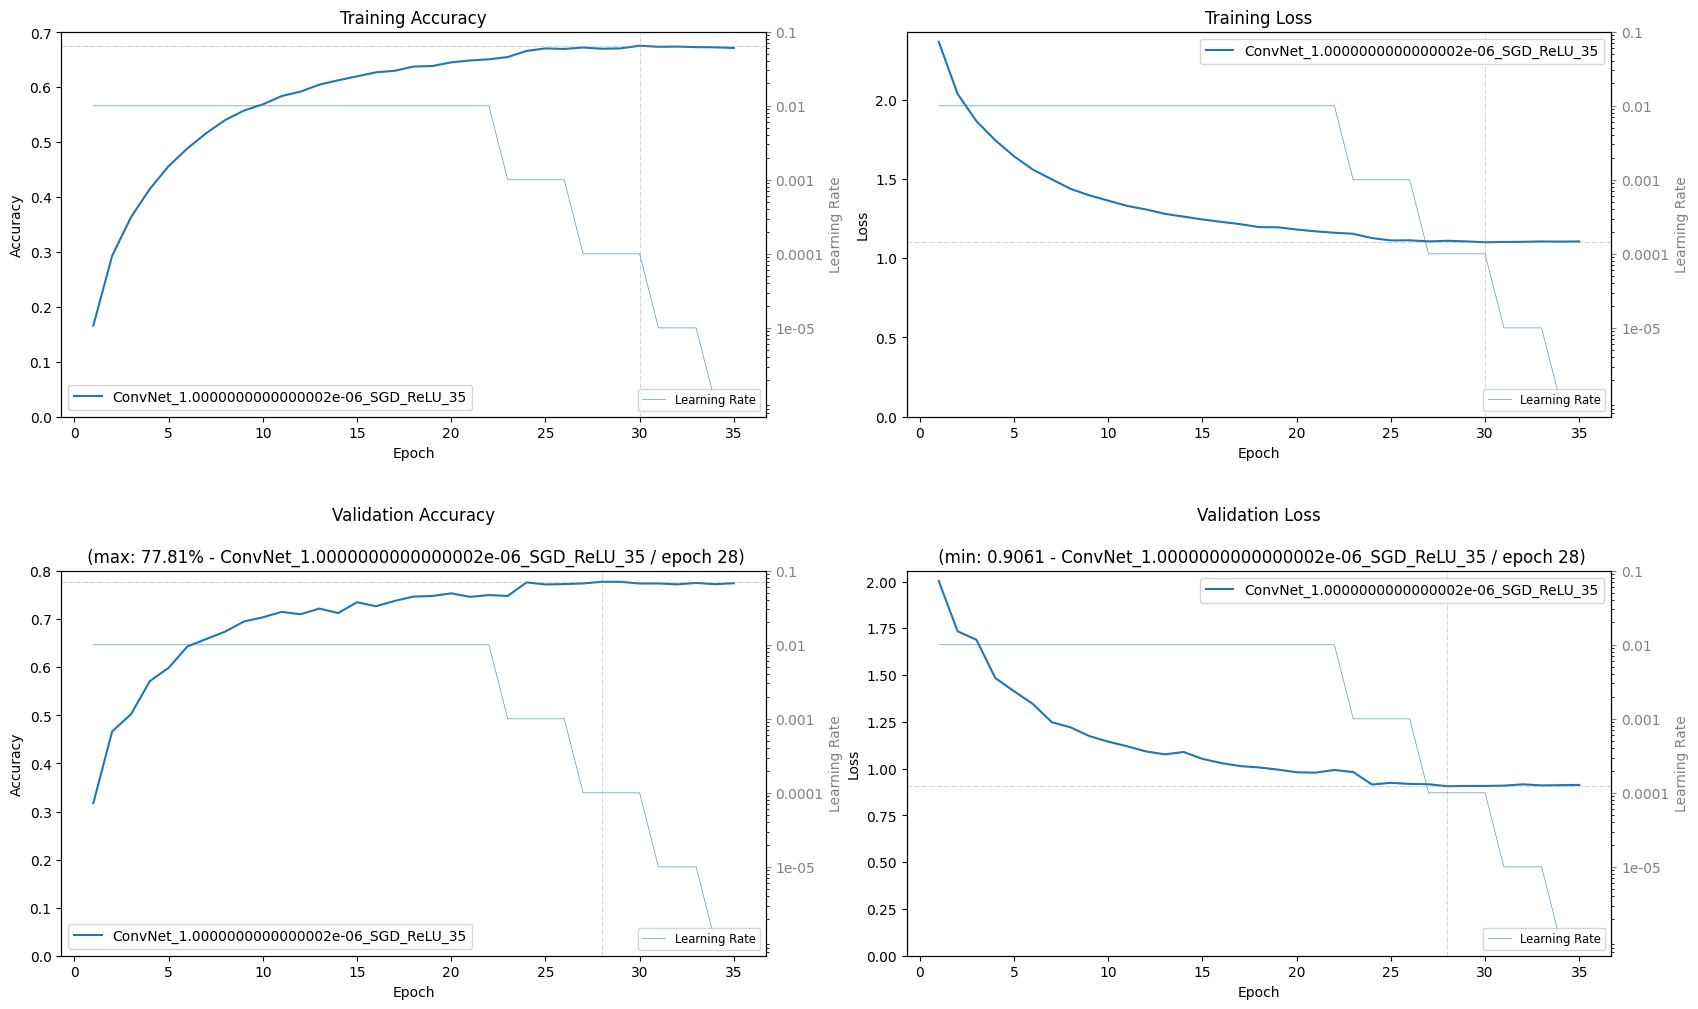

In [ ]:
def plot_metrics():
    time.sleep(5) # eliminating errors related to the delays with Google Drive update after saving the metrics

    # Load the most recently created metrics dictionaries from files and convert them to CPU
    all_train_accuracies_cpu, all_train_losses_cpu, all_val_accuracies_cpu, all_val_losses_cpu, all_learning_rates_cpu = load_dicts_from_files(pickle_files, accuracy_folder)

    fig, axs = plt.subplots(2, 2, figsize=(20, 12))
    fig.subplots_adjust(hspace=0.4)

    # Add a secondary y-axis for learning rates
    axs_lr = [ax.twinx() for ax in axs.flatten()]

    def plot_learning_rates(axs_lr, setting, all_learning_rates_cpu, color, label=None):
        lr_history = all_learning_rates_cpu[setting][:len(accuracies)]
        axs_lr.plot(range(1, len(lr_history) + 1),
                    lr_history,
                    linestyle='-', color=color, linewidth=0.5, alpha=0.75, label=label)

        axs_lr.set_ylabel("Learning Rate", color='gray')
        axs_lr.tick_params(axis='y', colors='gray')
        axs_lr.set_yscale('log')  # log scale for the y-axis
        y_ticks = [0.1, 0.01, 0.001, 0.0001, 0.00001]
        axs_lr.set_yticks(y_ticks)  # Set the y-ticks

        formatter = FuncFormatter(lambda x, pos: f"{x:.0}".rstrip("0").rstrip(".") if x > 0 else "")
        axs_lr.get_yaxis().set_major_formatter(formatter)
        axs_lr.legend(loc='lower right', fontsize='small')

    xticks = np.arange(1, len(all_train_accuracies_cpu.values()) + 1)

    max_train_acc_value = max([max(accuracies) for accuracies in all_train_accuracies_cpu.values()])
    max_train_acc_setting = max(all_train_accuracies_cpu, key=lambda key: max(all_train_accuracies_cpu[key]))
    max_train_acc_epoch = all_train_accuracies_cpu[max_train_acc_setting].index(max_train_acc_value) + 1

    max_val_acc_value = max([max(accuracies) for accuracies in all_val_accuracies_cpu.values()])
    max_val_acc_setting = max(all_val_accuracies_cpu, key=lambda key: max(all_val_accuracies_cpu[key]))
    max_val_acc_epoch = all_val_accuracies_cpu[max_val_acc_setting].index(max_val_acc_value) + 1

    min_train_loss_value = min([min(losses) for losses in all_train_losses_cpu.values()])
    min_train_loss_setting = min(all_train_losses_cpu, key=lambda key: min(all_train_losses_cpu[key]))
    min_train_loss_epoch = all_train_losses_cpu[min_train_loss_setting].index(min_train_loss_value) + 1

    min_val_loss_value = min([min(losses) for losses in all_val_losses_cpu.values()])
    min_val_loss_setting = min(all_val_losses_cpu, key=lambda key: min(all_val_losses_cpu[key]))
    min_val_loss_epoch = all_val_losses_cpu[min_val_loss_setting].index(min_val_loss_value) + 1

    for i, (setting, accuracies) in enumerate(all_train_accuracies_cpu.items()):
        xticks = np.arange(1, len(accuracies) + 1)
        line = axs[0, 0].plot(range(1, len(accuracies) + 1), accuracies, label=setting)
        #axs[0, 0].set_xticks(xticks[::2])
        #axs[0, 0].set_ylim(top=max_train_acc_value*1.1)
        color = line[0].get_color()
        # Plot learning rates on the secondary y-axis
        plot_learning_rates(axs_lr[0], setting, all_learning_rates_cpu, color = color, label ='Learning Rate' if i == 0 else None)

    axs[0, 0].set_xlabel("Epoch")
    axs[0, 0].set_ylabel("Accuracy")
    axs[0, 0].set_title("Training Accuracy")
    axs[0, 0].set_ylim(bottom=0)  # Set the y-axis range to start from 0
    axs[0, 0].legend(loc='lower left')

    for i, (setting, losses) in enumerate(all_train_losses_cpu.items()):
        line = axs[0, 1].plot(range(1, len(losses) + 1), losses, label=setting)
        #axs[0, 1].set_xticks(xticks[::2])
        #axs[0, 1].set_ylim(top=min_train_loss_value*1.1)
        color = line[0].get_color()
        # Plot learning rates on the secondary y-axis
        plot_learning_rates(axs_lr[1], setting, all_learning_rates_cpu, color, label='Learning Rate' if i == 0 else None)

    axs[0, 1].set_xlabel("Epoch")
    axs[0, 1].set_ylabel("Loss")
    axs[0, 1].set_title("Training Loss")
    axs[0, 1].set_ylim(bottom=0)  # Set the y-axis range to start from 0
    axs[0, 1].legend(loc='upper right')

    for i, (setting, accuracies) in enumerate(all_val_accuracies_cpu.items()):
        line = axs[1, 0].plot(range(1, len(accuracies) + 1), accuracies, label=setting)
        #axs[1, 0].set_xticks(xticks[::2])
        #axs[1, 0].set_ylim(top=max_val_acc_value*1.1)
        color = line[0].get_color()
        # Plot learning rates on the secondary y-axis
        plot_learning_rates(axs_lr[2], setting, all_learning_rates_cpu, color, label='Learning Rate' if i == 0 else None)

    axs[1, 0].set_xlabel("Epoch")
    axs[1, 0].set_ylabel("Accuracy")
    axs[1, 0].set_title(f"Validation Accuracy\n\n (max: {max_val_acc_value * 100:.2f}% - {max_val_acc_setting} / epoch {max_val_acc_epoch})")
    axs[1, 0].set_ylim(bottom=0)  # Set the y-axis range to start from 0
    axs[1, 0].legend(loc='lower left')

    for i, (setting, losses) in enumerate(all_val_losses_cpu.items()):
        line = axs[1, 1].plot(range(1, len(losses) + 1), losses, label=setting)
        #axs[1, 1].set_xticks(xticks[::2])
        #axs[1, 1].set_ylim(top=min_val_loss_value*1.1)
        color = line[0].get_color()
        # Plot learning rates on the secondary y-axis
        plot_learning_rates(axs_lr[3], setting, all_learning_rates_cpu, color, label='Learning Rate' if i == 0 else None)

    axs[1, 1].set_xlabel("Epoch")
    axs[1, 1].set_ylabel("Loss")
    axs[1, 1].set_title(f"Validation Loss\n\n (min: {min_val_loss_value:.4f} - {min_val_loss_setting} / epoch {min_val_loss_epoch})")
    axs[1, 1].set_ylim(bottom=0)  # Set the y-axis range to start from 0
    axs[1, 1].legend(loc='upper right')

    # Add dashed lines for highest achieved accuracy and lowest loss on the best epoch
    axs[0, 0].axhline(y=max_train_acc_value, linestyle='dashdot', color='gray', linewidth=0.5, alpha=0.5, label=f'max accuracy: {max_train_acc_value * 100:.2f}%')
    axs[0, 0].axvline(x=max_train_acc_epoch , linestyle='dashdot', color='gray', linewidth=0.5, alpha=0.5, label=f'max accuracy: {max_train_acc_epoch}')

    axs[0, 1].axhline(y=min_train_loss_value, linestyle='dashdot', color='gray', linewidth=0.5, alpha=0.5, label=f'max accuracy: {min_train_loss_value}')
    axs[0, 1].axvline(x=min_train_loss_epoch, linestyle='dashdot', color='gray', linewidth=0.5, alpha=0.5, label=f'min loss epoch: {min_train_loss_epoch}')

    axs[1, 0].axhline(y=max_val_acc_value, linestyle='dashdot', color='gray', linewidth=0.5, alpha=0.5, label=f'max accuracy: {max_val_acc_value * 100:.2f}%')
    axs[1, 0].axvline(x=max_val_acc_epoch, linestyle='dashdot', color='gray', linewidth=0.5, alpha=0.5, label=f'max accuracy epoch: {max_val_acc_epoch}')

    axs[1, 1].axhline(y=min_val_loss_value, linestyle='dashdot', color='gray', linewidth=0.5, alpha=0.5, label=f'min loss: {min_val_loss_value:.4f}')
    axs[1, 1].axvline(x=min_val_loss_epoch, linestyle='dashdot', color='gray', linewidth=0.5, alpha=0.5, label=f'min loss epoch: {min_val_loss_epoch}')

    plt.show()

plot_metrics()

Testing progress:   0%|          | 0/204 [00:00<?, ?it/s]

                           Test accuracy: 76.50%


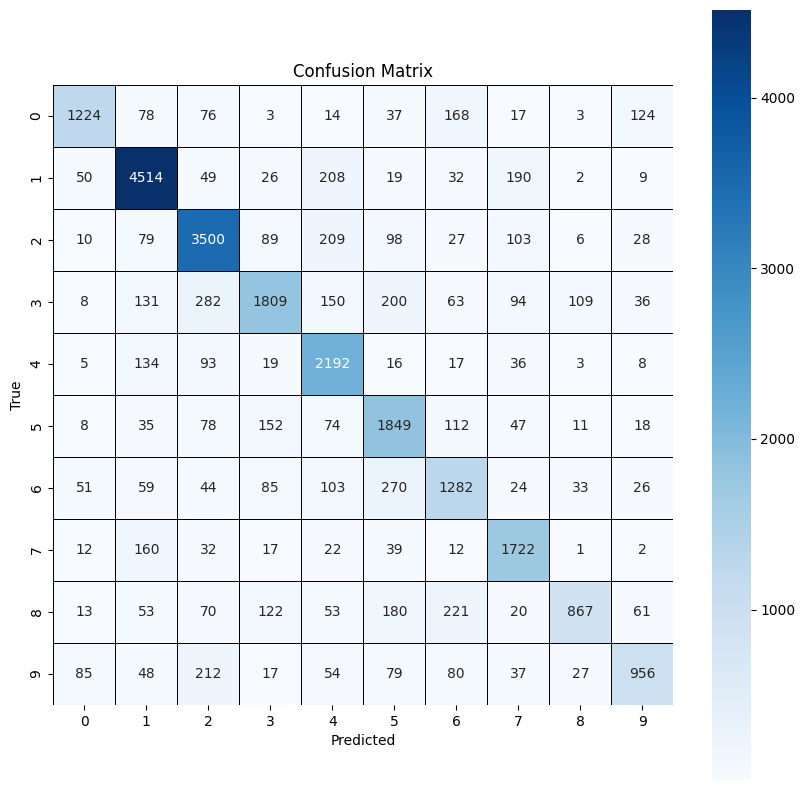

Classification Report:

              precision    recall  f1-score   support

           0       0.83      0.70      0.76      1744
           1       0.85      0.89      0.87      5099
           2       0.79      0.84      0.82      4149
           3       0.77      0.63      0.69      2882
           4       0.71      0.87      0.78      2523
           5       0.66      0.78      0.72      2384
           6       0.64      0.65      0.64      1977
           7       0.75      0.85      0.80      2019
           8       0.82      0.52      0.64      1660
           9       0.75      0.60      0.67      1595

    accuracy                           0.77     26032
   macro avg       0.76      0.73      0.74     26032
weighted avg       0.77      0.77      0.76     26032

tensor([[0.0242, 0.0268, 0.0263,  ..., 0.2062, 0.0905, 0.0348],
        [0.0380, 0.0047, 0.8069,  ..., 0.0224, 0.0278, 0.0243],
        [0.0202, 0.6396, 0.0738,  ..., 0.0166, 0.0244, 0.0165],
        ...,
        [0.0

In [ ]:
# Testing the best model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the saved model
model_path = os.path.join(mount_point, project_folder, f'best_model.pth')

# Set the model to evaluation mode
for model_dict in model_list:

    model_name = model_dict["name"]
    model_class = model_dict["model"]

model = model_class(nn.ReLU()).to(device)
model.eval()

# Load the model weights
if device.type == 'cuda':
    model.load_state_dict(torch.load(model_path))
else:
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

all_preds = []
all_labels = []

softmax_scores = []
image_names = []

test_progress_bar = tqdm(dataloaders['test'], desc='Testing progress')

for inputs, labels in test_progress_bar:
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(inputs)
        softmax = torch.nn.functional.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())
    softmax_scores.append(softmax.cpu())

    # Update progress bar
    test_progress_bar.set_postfix(acc=torch.sum(preds == labels.data))

accuracy = accuracy_score(all_labels, all_preds)
print(f'                           Test accuracy: {accuracy * 100:.2f}%')

softmax_scores = torch.cat(softmax_scores)

# Plotting confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True, linewidths=0.5, linecolor='black', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
report = classification_report(all_labels, all_preds, target_names=class_names)
print('Classification Report:\n')
print(report)

print(softmax_scores)

**Combined metrics plot**

In [ ]:
# Set the project folders
mount_point = '/content/drive/'
data_folder = '/content/data'

if not os.path.exists(mount_point):
    drive.mount(mount_point)
else:
    print(f"Drive is already mounted at {mount_point}")

os.chdir(os.path.join(mount_point))

project_folder = os.path.join(mount_point, 'MyDrive/D7047E/SVHN/')

accuracy_folders = [
        os.path.join(mount_point, project_folder, 'accuracy_fc2'),
        os.path.join(mount_point, project_folder, 'accuracy_fc1_bn5_dropout3_fc2'),]

pickle_files = [
    "all_train_accuracies.pickle",
    "all_train_losses.pickle",
    "all_val_accuracies.pickle",
    "all_val_losses.pickle",
    "all_learning_rates.pickle",]

Drive is already mounted at /content/drive/


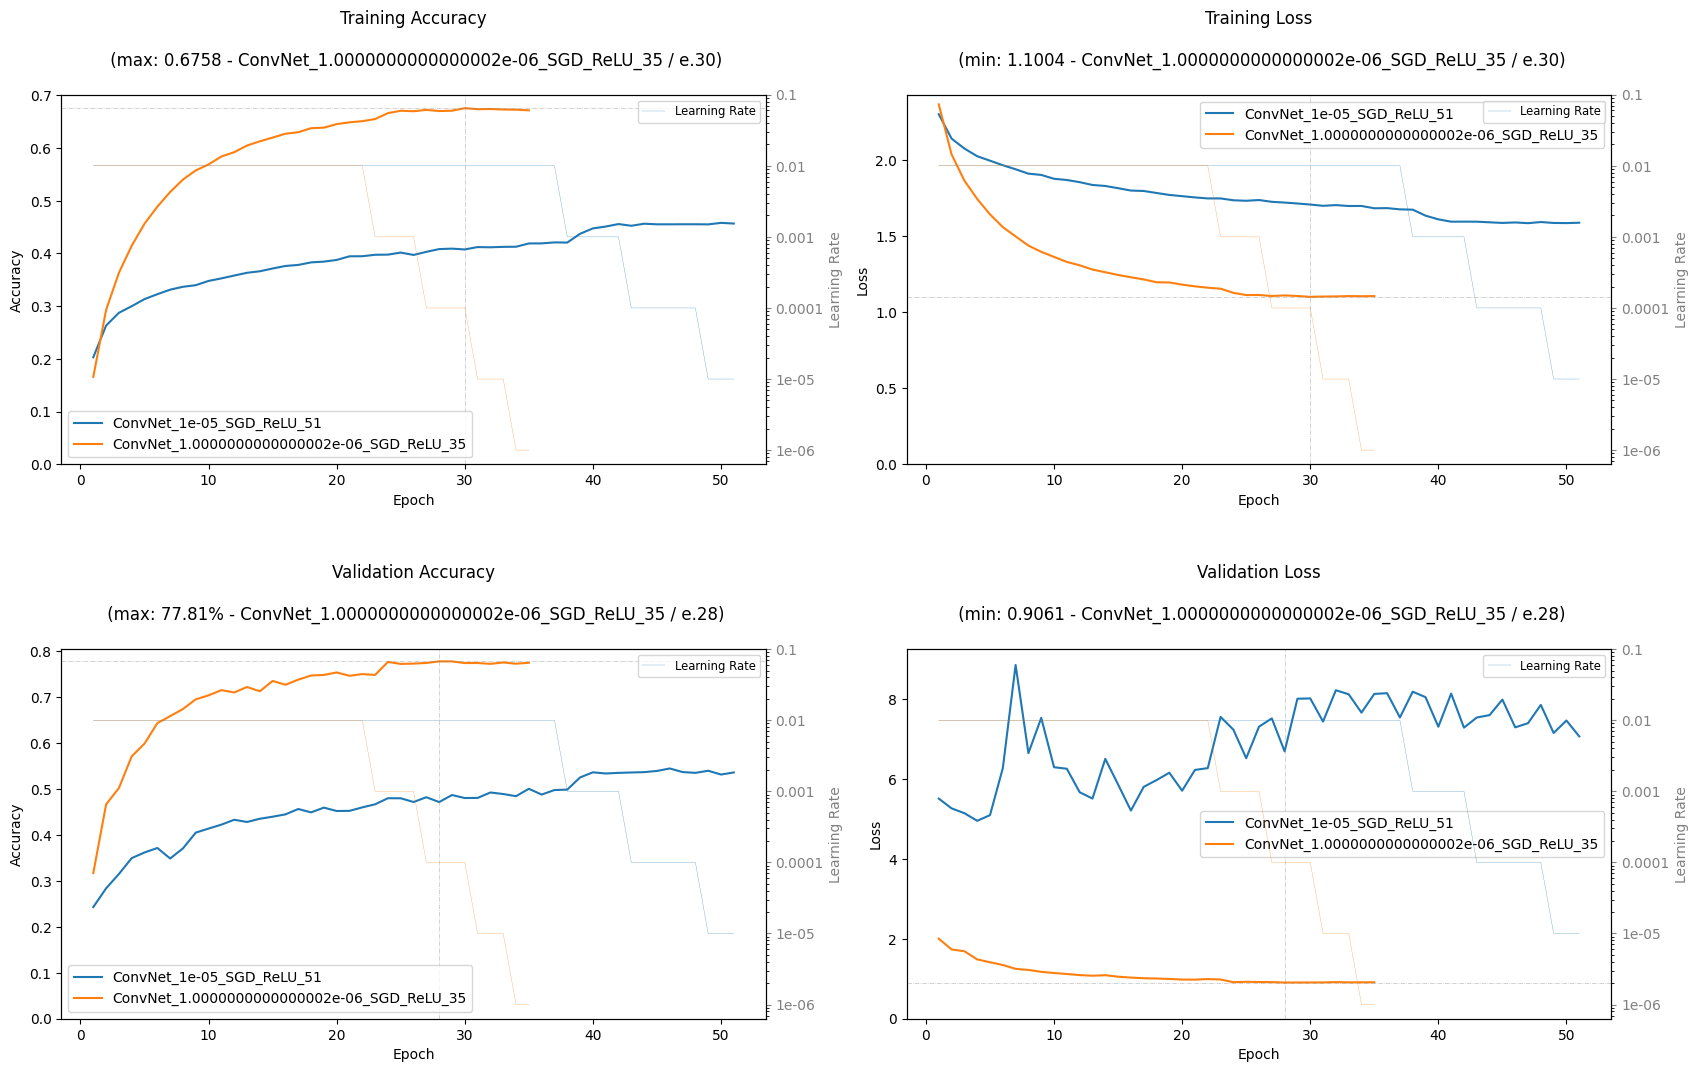

In [ ]:
def convert_to_cpu(tensor_list):
    return [tensor.cpu().numpy() if isinstance(tensor, torch.Tensor) else tensor for tensor in tensor_list]


def load_dicts_from_files(pickle_files, accuracy_folder):
    loaded_dicts = []
    for file in pickle_files:
        file_name = os.path.join(accuracy_folder, file)
        with open(file_name, "rb") as handle:
            data_dict = pickle.load(handle)

            # Convert to CPU
            data_dict_cpu = {k: convert_to_cpu(v) for k, v in data_dict.items()}
            loaded_dicts.append(data_dict_cpu)
    return loaded_dicts

def plot_metrics():
    time.sleep(5) # eliminating errors related to the delays with Google Drive update after saving the metrics

    all_train_accuracies_cpu = {}
    all_train_losses_cpu = {}
    all_val_accuracies_cpu = {}
    all_val_losses_cpu = {}
    all_learning_rates_cpu = {}

    # Load the most recently created metrics dictionaries from files and convert them to CPU
    for merged in accuracy_folders:
        merged_train_accuracies, merged_train_losses, merged_val_accuracies, merged_val_losses, merged_learning_rates = load_dicts_from_files(pickle_files, merged)

        all_train_accuracies_cpu.update(merged_train_accuracies)
        all_train_losses_cpu.update(merged_train_losses)
        all_val_accuracies_cpu.update(merged_val_accuracies)
        all_val_losses_cpu.update(merged_val_losses)
        all_learning_rates_cpu.update(merged_learning_rates)

    fig, axs = plt.subplots(2, 2, figsize=(20, 12))
    fig.subplots_adjust(hspace=0.5)

    # Add a secondary y-axis for learning rates
    axs_lr = [ax.twinx() for ax in axs.flatten()]

    def plot_learning_rates(axs_lr, setting, all_learning_rates_cpu, color, label=None):
        lr_history = all_learning_rates_cpu[setting]
        epochs = np.arange(1, len(lr_history) + 1)

        axs_lr.plot(epochs, lr_history, linestyle='-', color=color, linewidth=0.25, alpha=0.75, label=label)

        axs_lr.set_ylabel("Learning Rate", color='gray')
        axs_lr.tick_params(axis='y', colors='gray')
        axs_lr.set_yscale('log')  # log scale for the y-axis
        y_ticks = [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
        axs_lr.set_yticks(y_ticks)  # Set the y-ticks

        formatter = FuncFormatter(lambda x, pos: f"{x:.0}".rstrip("0").rstrip(".") if x > 0 else "")
        axs_lr.get_yaxis().set_major_formatter(formatter)
        axs_lr.legend(loc='best', fontsize='small')


    xticks = np.arange(1, len(all_train_accuracies_cpu.values()) + 1)

    max_train_acc_value = max([max(accuracies) for accuracies in all_train_accuracies_cpu.values()])
    max_train_acc_setting = max(all_train_accuracies_cpu, key=lambda key: max(all_train_accuracies_cpu[key]))
    max_train_acc_epoch = all_train_accuracies_cpu[max_train_acc_setting].index(max_train_acc_value) + 1

    max_val_acc_value = max([max(accuracies) for accuracies in all_val_accuracies_cpu.values()])
    max_val_acc_setting = max(all_val_accuracies_cpu, key=lambda key: max(all_val_accuracies_cpu[key]))
    max_val_acc_epoch = all_val_accuracies_cpu[max_val_acc_setting].index(max_val_acc_value) + 1

    min_train_loss_value = min([min(losses) for losses in all_train_losses_cpu.values()])
    min_train_loss_setting = min(all_train_losses_cpu, key=lambda key: min(all_train_losses_cpu[key]))
    min_train_loss_epoch = all_train_losses_cpu[min_train_loss_setting].index(min_train_loss_value) + 1

    min_val_loss_value = min([min(losses) for losses in all_val_losses_cpu.values()])
    min_val_loss_setting = min(all_val_losses_cpu, key=lambda key: min(all_val_losses_cpu[key]))
    min_val_loss_epoch = all_val_losses_cpu[min_val_loss_setting].index(min_val_loss_value) + 1

    for i, (setting, accuracies) in enumerate(all_train_accuracies_cpu.items()):
        xticks = np.arange(1, len(accuracies) + 1)
        line = axs[0, 0].plot(range(1, len(accuracies) + 1), accuracies, label=setting)
        #axs[0, 0].set_xticks(xticks[::2])
        color = line[0].get_color()
        # Plot learning rates on the secondary y-axis
        plot_learning_rates(axs_lr[0], setting, all_learning_rates_cpu, color = color, label ='Learning Rate' if i == 0 else None)

    axs[0, 0].set_xlabel("Epoch")
    axs[0, 0].set_ylabel("Accuracy")
    #axs[0, 0].set_title("Training Accuracy")
    axs[0, 0].set_title(f"Training Accuracy\n\n (max: {max_train_acc_value:.4f} - {max_train_acc_setting} / e.{max_train_acc_epoch})\n")
    axs[0, 0].set_ylim(bottom=0)  # Set the y-axis range to start from 0
    axs[0, 0].legend(loc='best')

    for i, (setting, losses) in enumerate(all_train_losses_cpu.items()):
        line = axs[0, 1].plot(range(1, len(losses) + 1), losses, label=setting)
        #axs[0, 1].set_xticks(xticks[::2])
        color = line[0].get_color()
        # Plot learning rates on the secondary y-axis
        plot_learning_rates(axs_lr[1], setting, all_learning_rates_cpu, color, label='Learning Rate' if i == 0 else None)

    axs[0, 1].set_xlabel("Epoch")
    axs[0, 1].set_ylabel("Loss")
    #axs[0, 1].set_title("Training Loss")
    axs[0, 1].set_title(f"Training Loss\n\n (min: {min_train_loss_value:.4f} - {min_train_loss_setting} / e.{min_train_loss_epoch})\n")

    axs[0, 1].set_ylim(bottom=0)  # Set the y-axis range to start from 0
    axs[0, 1].legend(loc='best')

    for i, (setting, accuracies) in enumerate(all_val_accuracies_cpu.items()):
        line = axs[1, 0].plot(range(1, len(accuracies) + 1), accuracies, label=setting)
        #axs[1, 0].set_xticks(xticks[::2])
        color = line[0].get_color()
        # Plot learning rates on the secondary y-axis
        plot_learning_rates(axs_lr[2], setting, all_learning_rates_cpu, color, label='Learning Rate' if i == 0 else None)

    axs[1, 0].set_xlabel("Epoch")
    axs[1, 0].set_ylabel("Accuracy")
    axs[1, 0].set_title(f"Validation Accuracy\n\n (max: {max_val_acc_value * 100:.2f}% - {max_val_acc_setting} / e.{max_val_acc_epoch})\n")
    axs[1, 0].set_ylim(bottom=0)  # Set the y-axis range to start from 0
    axs[1, 0].legend(loc='best')

    for i, (setting, losses) in enumerate(all_val_losses_cpu.items()):
        line = axs[1, 1].plot(range(1, len(losses) + 1), losses, label=setting)
        #axs[1, 1].set_xticks(xticks[::2])
        color = line[0].get_color()
        # Plot learning rates on the secondary y-axis
        plot_learning_rates(axs_lr[3], setting, all_learning_rates_cpu, color, label='Learning Rate' if i == 0 else None)

    axs[1, 1].set_xlabel("Epoch")
    axs[1, 1].set_ylabel("Loss")
    axs[1, 1].set_title(f"Validation Loss\n\n (min: {min_val_loss_value:.4f} - {min_val_loss_setting} / e.{min_val_loss_epoch})\n")
    axs[1, 1].set_ylim(bottom=0)  # Set the y-axis range to start from 0
    axs[1, 1].legend(loc='best')

    # Add dashed lines for highest achieved accuracy and lowest loss on the best epoch
    axs[0, 0].axhline(y=max_train_acc_value, linestyle='dashdot', color='gray', linewidth=0.5, alpha=0.5, label=f'max accuracy: {max_train_acc_value * 100:.2f}%')
    axs[0, 0].axvline(x=max_train_acc_epoch , linestyle='dashdot', color='gray', linewidth=0.5, alpha=0.5, label=f'max accuracy: {max_train_acc_epoch}')

    axs[0, 1].axhline(y=min_train_loss_value, linestyle='dashdot', color='gray', linewidth=0.5, alpha=0.5, label=f'max accuracy: {min_train_loss_value}')
    axs[0, 1].axvline(x=min_train_loss_epoch, linestyle='dashdot', color='gray', linewidth=0.5, alpha=0.5, label=f'min loss epoch: {min_train_loss_epoch}')

    axs[1, 0].axhline(y=max_val_acc_value, linestyle='dashdot', color='gray', linewidth=0.5, alpha=0.5, label=f'max accuracy: {max_val_acc_value * 100:.2f}%')
    axs[1, 0].axvline(x=max_val_acc_epoch, linestyle='dashdot', color='gray', linewidth=0.5, alpha=0.5, label=f'max accuracy epoch: {max_val_acc_epoch}')

    axs[1, 1].axhline(y=min_val_loss_value, linestyle='dashdot', color='gray', linewidth=0.5, alpha=0.5, label=f'min loss: {min_val_loss_value:.4f}')
    axs[1, 1].axvline(x=min_val_loss_epoch, linestyle='dashdot', color='gray', linewidth=0.5, alpha=0.5, label=f'min loss epoch: {min_val_loss_epoch}')

    #for ax in axs.flatten():
    #    ax.set_xlim(1, 50)

    plt.show()

plot_metrics()